In [1]:
#from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
#from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display
import networkx as nx


import flylib as flb
#from thllib import flylib as flb
import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from flylib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display
import pandas as pd
import networkx as nx

/home/imager/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
%matplotlib inline

In [3]:
fly_nums = range(1707, 1709) + range(1711, 1714) + range (1715, 1719) + range(1719, 1722) + range(1722, 1727) + range(1729, 1730)# +   range(1731, 1732)## last one are the newest trials -- 
#figure out whats wrong with kine cam?
multi_fly_df = util.construct_multi_fly_df(fly_nums)

Making dataframe for fly number 1707
Making dataframe for fly number 1708
Making dataframe for fly number 1711
Making dataframe for fly number 1712
Making dataframe for fly number 1713
Making dataframe for fly number 1715
Making dataframe for fly number 1716
Making dataframe for fly number 1717
Making dataframe for fly number 1718
Making dataframe for fly number 1719
Making dataframe for fly number 1720
Making dataframe for fly number 1721
Making dataframe for fly number 1722
Making dataframe for fly number 1723
Making dataframe for fly number 1724
Making dataframe for fly number 1725
Making dataframe for fly number 1726
Making dataframe for fly number 1729


In [4]:
flynumbers = list(range(1389,1402))

fly_nums = range(1389,1402)#,1545)
#fly_nums = range(1635, 1637) + range(1637, 1639) + range(1640, 1643) + range(1645, 1647) + range(1648, 1651) + range(1653, 1654) #+ range(1655, 1656) 
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]

In [5]:
sorted_keys = sorted(fly.spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

flydict = {}
for fly in flylist:
    flydict[fly.flynum] = fly
    
stim_conditions = [('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0')]

In [6]:
print(multi_fly_df.columns.values)
print(np.unique(multi_fly_df['stimulus']))

idx = (multi_fly_df['stimulus']=='cl_blocks, g_x=-1, g_y=0, b_x=-8, b_y=0, ch=True')& \
        ((multi_fly_df['amp_diff']>0.1)&(multi_fly_df['amp_diff']<0.104))


['t' 'stimulus' 'amp_diff' 'left_amp' 'right_amp' 'fly_num' 'wbf'
 'experimental_condition' 'pr_left' 'tpd_left' 'nm_left' 'iii1_left'
 'iii3_left' 'i2_left' 'hg2_left' 'hg3_left' 'hg1_left' 'i1_left'
 'bkg_left' 'b1_left' 'b2_left' 'b3_left' 'iii24_left' 'hg4_left'
 'pr_right' 'tpd_right' 'nm_right' 'iii1_right' 'iii3_right' 'i2_right'
 'hg2_right' 'hg3_right' 'hg1_right' 'i1_right' 'bkg_right' 'b1_right'
 'b2_right' 'b3_right' 'iii24_right' 'hg4_right']
['exc_cl_starfield, g_x = 1, g_y=0, b_x =0, b_y = 0, ch=0'
 'pitch_down_actually_roll, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'
 'pitch_up_actually_roll, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'
 'pretrial_stripe_fix'
 'roll_clockwise_actually_pitch, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'
 'roll_counterclockwise_actually_pitch, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'
 'trials_ended' 'yaw_left, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'
 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']


In [11]:
def plot_sector_kine(flylist,
                sector,ax,
                pathspecs,
                mode = 'hist',
                contours = False,
                rng = (25,95)):
    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',

                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',

                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}

    block_key = sector_map[sector]

    if mode == 'hist':
        group_hist = get_group_hist(flylist,
                                 xkey,
                                 ykey,
                                 block_keys = [block_key],
                                 condition_keys = ['condition=test'])
        sector_mask = np.array([group_hist>0.5]*4)
        ps = pathspecs[sector]
        fc = ps.mplkwargs()['facecolor']
        sector_img = (sector_mask*fc[:,None,None]).T
        ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))
    if mode == 'kde':
        group_hists = get_kde_estimates_kine(flylist,rng = rng,
                                             block_keys = [block_key],
                                 condition_keys = ['condition=test'],
                                 bandwidth = 5,
                                 nbins = 100)
        print np.shape(group_hists)
        group_hists = np.product(group_hists,axis = 0)
        if contours:
            #sector_mask = np.array(group_hists>0.001*4)
            #pad the mask to deal with corners and edges
            sector_mask = group_hists
            padr = np.zeros(np.shape(sector_mask)[1])
            sector_mask = np.vstack((padr,sector_mask,padr))
            padc = np.zeros((np.shape(sector_mask)[0],1)) 
            sector_mask = np.hstack((padc,sector_mask,padc))
            #get the contour
            from skimage import measure
            level = np.percentile(group_hists,90)
            contours = measure.find_contours(sector_mask,level)
            if len(contours) > 1:
                print('more than one contour found')
                contour = contours[np.argmax([len(c) for c in contours])].T
            else:
                contour = contours[0].T
            #put back in data coords
            cy = (contour[0]-1)/(np.shape(sector_mask)[0]-1)
            cx = (contour[1]-1)/(np.shape(sector_mask)[1]-1)
            
            cy =cy*(rng[1]-rng[0]) + rng[0]
            cx =cx*(rng[1]-rng[0]) + rng[0]
            
            if (cy[0] != cy[-1]) | (cx[0] != cx[-1]):
                #close the contours
                cy = np.hstack([cy,cy[0]])
                cx = np.hstack([cx,cx[0]])
            ps = pathspecs[sector]
            kwargs = ps.mplkwargs()
            ax.fill(cx,cy,clip_on = False,**kwargs)
        else:
            sector_mask = np.array([group_hists>0.001]*4)
            ps = pathspecs[sector]
            fc = ps.mplkwargs()['facecolor']
            sector_img = np.transpose(sector_mask*fc[:,None,None],(1,2,0))[::-1,:,:]
            ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))

In [12]:
def plot_sector(flylist,
                xkey,ykey,
                sector,ax,
                pathspecs,
                mode = 'hist',
                contours = False):
    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',
                  
                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',
                  
                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}
    
    block_key = sector_map[sector]
    if mode == 'hist':
        group_hist = get_group_hist(flylist,
                                 xkey,
                                 ykey,
                                 block_keys = [block_key],
                                 condition_keys = ['condition=test'])
        sector_mask = np.array([group_hist>0.5]*4)
        ps = pathspecs[sector]
        fc = ps.mplkwargs()['facecolor']
        sector_img = (sector_mask*fc[:,None,None]).T
        ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))
    if mode == 'kde':
        group_hists = get_kde_estimates(flylist,
                                 xkey,
                                 ykey,
                                 block_keys = [block_key],
                                 condition_keys = ['condition=test'],
                                 bandwidth = 0.1,
                                 nbins = 100)
        group_hists = np.product(group_hists,axis = 0)
        if contours:
            #sector_mask = np.array(group_hists>0.001*4)
            #pad the mask to deal with corners and edges
            sector_mask = group_hists
            padr = np.zeros(np.shape(sector_mask)[1])
            sector_mask = np.vstack((padr,sector_mask,padr))
            padc = np.zeros((np.shape(sector_mask)[0],1)) 
            sector_mask = np.hstack((padc,sector_mask,padc))
            #get the contour
            from skimage import measure
            contours = measure.find_contours(sector_mask,30.5)
            if len(contours) > 1:
                print('more than one contour found for:')
                print('%s %s - %s %s'%(xkey + ykey))
                contour = contours[np.argmax([len(c) for c in contours])].T
            else:
                contour = contours[0].T
            #put back in data coords
            cy = (contour[0]-1)/(np.shape(sector_mask)[0]-1)
            cx = (contour[1]-1)/(np.shape(sector_mask)[1]-1)
            if (cy[0] != cy[-1]) | (cx[0] != cx[-1]):
                #close the contours
                cy = np.hstack([cy,cy[0]])
                cx = np.hstack([cx,cx[0]])
            ps = pathspecs[sector]
            #fc = ps.mplkwargs()['facecolor']
            #ec = ps.mplkwargs()['edgecolor']
            kwargs = ps.mplkwargs()
            ax.fill(cx,cy,clip_on = False,**kwargs)
        else:
            sector_mask = np.array([group_hists>0.001]*4)
            ps = pathspecs[sector]
            fc = ps.mplkwargs()['facecolor']
            sector_img = np.transpose(sector_mask*fc[:,None,None],(1,2,0))[::-1,:,:]
            ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))


In [7]:
def get_kde_estimates(flies,xkey,ykey,
                      condition_keys = [],
                      block_keys = [],
                      nbins = 50,bandwidth = 0.05):
    from sklearn.neighbors.kde import KernelDensity
    pdfs = []
    for fly in flies:
        try:
            dmask = fly.data_mask
            c_masks = []
            b_masks = []

            for ckey in condition_keys:
                c_masks.append(np.array(fly.experimental_condition) == ckey)
            for bkey in block_keys:
                b_masks.append(np.array(fly.experimental_block) == bkey)
            if len(c_masks)>0:
                if len(b_masks)>0:
                    dmask = dmask & np.any(b_masks,axis = 0) & np.any(c_masks,axis = 0)
                else:
                    dmask = dmask & np.any(c_masks,axis = 0)
            else:
                if len(b_masks)>0:
                    dmask = dmask & np.any(b_masks,axis = 0)

            x = fly.non_neg_signals[xkey][dmask]
            y = fly.non_neg_signals[ykey][dmask]
            X = np.array([x,y])
            xedges = np.linspace(0,1,nbins)
            yedges = np.linspace(0,1,nbins)
            gridx,gridy = np.meshgrid(xedges,yedges)
            kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X.T)
            smps = kde.score_samples(np.vstack((gridx.ravel(),gridy.ravel())).T)
            pdfs.append((np.exp(smps.reshape(np.shape(gridx)))))
        except ValueError:
            pass
    return pdfs

In [8]:
def get_kde_estimates_kine(flies,rng = (25,95),
                      condition_keys = [],
                      block_keys = [],
                      nbins = 50,bandwidth = 10):
    from sklearn.neighbors.kde import KernelDensity
    #from thllib import util
    from flylib import util
    pdfs = []
    for fly in flies:
        #try:
        dmask = fly.data_mask
        c_masks = []
        b_masks = []

        for ckey in condition_keys:
            c_masks.append(np.array(fly.experimental_condition) == ckey)
        for bkey in block_keys:
            b_masks.append(np.array(fly.experimental_block) == bkey)
        if len(c_masks)>0:
            if len(b_masks)>0:
                dmask = dmask & np.any(b_masks,axis = 0) & np.any(c_masks,axis = 0)
            else:
                dmask = dmask & np.any(c_masks,axis = 0)
        else:
            if len(b_masks)>0:
                dmask = dmask & np.any(b_masks,axis = 0)

        x = util.fill_nan(np.rad2deg(np.array(fly.left_amp)[dmask]))
        y = util.fill_nan(np.rad2deg(np.array(fly.right_amp)[dmask]))
        X = np.array([x,y])
        X[np.isnan(X)] = 0
        X = np.squeeze(X)
        xedges = np.linspace(rng[0],rng[1],nbins)
        yedges = np.linspace(rng[0],rng[1],nbins)
        gridx,gridy = np.meshgrid(xedges,yedges)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X.T)
        smps = kde.score_samples(np.vstack((gridx.ravel(),gridy.ravel())).T)
        pdfs.append((np.exp(smps.reshape(np.shape(gridx)))))
        #except ValueError:
        #    pass
    return pdfs

In [9]:
def make_scatter_plots(fly,ax_group):
    """create summary plot for each fly in flylist, uses the template 
    file cov_matrix_triang_layout.svg, the hdf5 data of each fly needs to 
    be loaded"""
    import figurefirst as fifi
    if 'data_mask' in fly.h5files.keys():
        #fifi.mpl_functions.kill_all_spines(layout)
        dmask = np.array(fly.data_mask)

        # keymap = {}
        #l = [keymap.update({key:(key_to_key(key[0]),key_to_key(key[1]))}) for key in layout.axes.keys()]
        #keymap.pop('flynum')
        for key1,g in ax_group.items():
            for key2,ax in g.items():
                try:
                    dkeys = (key_to_key(key1),key_to_key(key2))
                    dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
                    dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
                    ax.scatter(dta1,dta2,
                               marker = 'o', #'.'
                               s = 0.9,
                               color = 'k',
                               alpha = 0.5,
                               edgecolors = 'none',
                               rasterized = True)
                    ax.set_xbound(0,1)
                    ax.set_ybound(0,1)
                    fifi.mpl_functions.kill_spines(ax)
                except KeyError:
                    if key == 'flynum':
                        ax.text(0,0,'Fly%s'%fly.flynum,size = 20)
                    else:
                        pass
            #layout.save('scatter_matrix_%s.svg'%fly.flynum)
            #plt.close('all')
        #display(SVG('scatter_matrix_%s.svg'%fly.flynum))
        
        

In [14]:
def scatter(fly, key1, key2, ax):
            dmask = np.array(fly.data_mask)
            dkeys = (key_to_key(key1),key_to_key(key2))
            dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
            dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
            ax.scatter(dta1,dta2,
                        marker = 'o', #'.'
                        s = 0.9,
                        color = 'k',
                        alpha = 0.9,
                        edgecolors = 'none',
                        rasterized = True)
            ax.set_xbound(0,1)
            ax.set_ybound(0,1)
            fifi.mpl_functions.kill_spines(ax)
            
'''           
def scatter_left_turn(fly, key1, key2, ax, sector):
    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',

                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',

                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}

    block_key = sector_map[sector]

    if mode == 'hist':
        group_hist = get_group_hist(flylist,
                                 xkey,
                                 ykey,
                                 block_keys = [block_key],
                                 condition_keys = ['condition=test'])
        sector_mask = np.array([group_hist>0.5]*4)
        ps = pathspecs[sector]
        fc = ps.mplkwargs()['facecolor']
        sector_img = (sector_mask*fc[:,None,None]).T
        ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))
            dmask = np.array(fly.data_mask)
            dkeys = (key_to_key(key1),key_to_key(key2))
            dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
            dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
            ax.scatter(dta1,dta2,
                        marker = 'o', #'.'
                        s = 0.9,
                        color = 'turquoise',
                        alpha = 0.9,
                        edgecolors = 'none',
                        rasterized = True)
            ax.set_xbound(0,1)
            ax.set_ybound(0,1)
            fifi.mpl_functions.kill_spines(ax)
            
def scatter_right_turn(fly, key1, key2, ax):
            dmask = np.array(fly.data_mask)
            dkeys = (key_to_key(key1),key_to_key(key2))
            dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
            dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
            ax.scatter(dta1,dta2,
                        marker = 'o', #'.'
                        s = 0.9,
                        color = 'r',
                        alpha = 0.9,
                        edgecolors = 'none',
                        rasterized = True)
            ax.set_xbound(0,1)
            ax.set_ybound(0,1)
            fifi.mpl_functions.kill_spines(ax)
'''

"           \ndef scatter_left_turn(fly, key1, key2, ax, sector):\n    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',\n                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',\n                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',\n\n                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',\n                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',\n                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',\n\n                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',\n                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',\n                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}\n\n    block_key = sector_map[sector]\n\n    if mode == 'hist':\n        group_hist = get_group_hist(flylist,\n                                 xkey,\n                                 ykey,\n                                 block_keys = [block_key],\n                                 condition_keys = ['condition

In [11]:
def key_to_key(inkey):
    """map the input key from the cov_mtrx_triang_layout.svg into a set of keys 
    (a tuple of tuples) that can be used to construct signals from the fly data"""
    try:
        k1 = {'R':'right','L':'left'}[inkey[0]]
    except KeyError:
        if inkey[0] == 'w':
            return ('common','wb_freq')
        else:
            return
    k2 = inkey[1:]
    return (k1,k2)

In [12]:
#Normalized Data
#normalized = (x-min(x))/(max(x)-min(x))

def normd (muscle_data):
    x = muscle_data
    normalized = (x-min(x))/(max(x)-min(x))
    return normalized

In [29]:
b1l = normd(fly.normed_signals['left', 'b1'])[idxs]
b1r = normd(fly.normed_signals['right', 'b1'])[idxs]

b2l = normd(fly.normed_signals['left', 'b2'])[idxs]
b2r = normd(fly.normed_signals['right', 'b2'])[idxs]

b3l = normd(fly.normed_signals['left', 'b3'])[idxs]
b3r = normd(fly.normed_signals['right', 'b3'])[idxs]

i1l = normd(fly.normed_signals['left', 'i1'])[idxs]
i1r = normd(fly.normed_signals['right', 'i1'])[idxs]

i2l = normd(fly.normed_signals['left', 'i2'])[idxs]
i2r = normd(fly.normed_signals['right', 'i2'])[idxs]

iii1l = normd(fly.normed_signals['left', 'iii1'])[idxs]
iii1r = normd(fly.normed_signals['right', 'iii1'])[idxs]

iii3l = normd(fly.normed_signals['left', 'iii3'])[idxs]
iii3r = normd(fly.normed_signals['right', 'iii3'])[idxs]

hg1l = normd(fly.normed_signals['left', 'hg1'])[idxs]
hg1r = normd(fly.normed_signals['right', 'hg1'])[idxs]

hg2l = normd(fly.normed_signals['left', 'hg2'])[idxs]
hg2r = normd(fly.normed_signals['right', 'hg2'])[idxs]

hg3l = normd(fly.normed_signals['left', 'hg3'])[idxs]
hg3r = normd(fly.normed_signals['right', 'hg3'])[idxs]

hg4l = normd(fly.normed_signals['left', 'hg4'])[idxs]
hg4r = normd(fly.normed_signals['right', 'hg4'])[idxs]


In [13]:
#import other dataset here 

yaw_left_df = pd.read_csv('yaw_left_df_nrm_1p5.csv')
yaw_right_df = pd.read_csv('yaw_right_df_nrm_1p5.csv')
pitch_up_df = pd.read_csv('pitch_up_df_nrm_1p5.csv')
pitch_down_df = pd.read_csv('pitch_down_df_nrm_1p5.csv')
roll_cw_df = pd.read_csv('roll_cw_df_nrm_1p5.csv')
roll_ccw_df = pd.read_csv('roll_ccw_df_nrm_1p5.csv')

In [14]:
def make_density_plots(fly,ax_group):
    """create summary plot for each fly in flylist, uses the template 
    file cov_matrix_triang_layout.svg, the hdf5 data of each fly needs to 
    be loaded"""
    import figurefirst as fifi
    if 'data_mask' in fly.h5files.keys():
        #fifi.mpl_functions.kill_all_spines(layout)
        dmask = np.array(fly.data_mask)

        # keymap = {}
        #l = [keymap.update({key:(key_to_key(key[0]),key_to_key(key[1]))}) for key in layout.axes.keys()]
        #keymap.pop('flynum')
        for key1,g in ax_group.items():
            for key2,ax in g.items():
                df=pd.DataFrame()
                try:
                    dkeys = (key_to_key(key1),key_to_key(key2))
                    dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
                    dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
                    df['x']= dta1
                    df['y']=dta2
                    #sns.displot(df, x='x', y= 'y', kind='kde', leves=[0.01, .05, .1, .5, .8], Fill=True, ax= ax)
                    sns.kdeplot(df.x, df.y, cmap='Blues', levels=[0.01, .05, .1, .5, .8], Fill=True, ax= ax)
                    #ax.scatter(dta1,dta2,
                    #           marker = '.',
                    #           s = 0.5,
                    #           color = 'k',
                    #           alpha = 0.5,
                    #           edgecolors = 'none',
                    #           rasterized = True)
                    ax.set_xbound(0,1)
                    ax.set_ybound(0,1)
                    fifi.mpl_functions.kill_spines(ax)
                except KeyError:
                    if key == 'flynum':
                        ax.text(0,0,'Fly%s'%fly.flynum,size = 20)
                    else:
                        pass
            #layout.save('scatter_matrix_%s.svg'%fly.flynum)
            #plt.close('all')
        #display(SVG('scatter_matrix_%s.svg'%fly.flynum))

In [38]:
import seaborn as sns
from scipy import stats

In [16]:
def scatter(fly, key1, key2, ax):
            df=pd.DataFrame()
            dmask = np.array(fly.data_mask)
            dkeys = (key_to_key(key1),key_to_key(key2))
            dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
            dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
            df['x']= dta1
            df['y']=dta2
            #sns.displot(df, x='x', y= 'y', kind='kde', leves=[0.01, .05, .1, .5, .8], Fill=True, ax= ax)
            #sns.kdeplot(df.x, df.y, cmap='Blues', levels=[.2, .5, .8, .9, .95, .99, .999, .999999], Fill=True, ax= ax)
            
            
            ######sns.kdeplot(df.x, df.y, cmap='Blues', fill=True, ax= ax) **this is what I used
            
            xmin = dta1.min()
            xmax = dta1.max()
            ymin = dta2.min()
            ymax = dta2.max()

            X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
            positions = np.vstack([X.ravel(), Y.ravel()])
            values = np.vstack([dta1, dta2])
            kernel = stats.gaussian_kde(values)
            Z = np.reshape(kernel(positions).T, X.shape)
            
            ax.imshow(np.rot90(Z), cmap=plt.cm.gray_r,
                      extent=[xmin, xmax, ymin, ymax])
            #ax.plot(m1, m2, 'k.', markersize=2)
            ax.set_xlim([xmin, xmax])
            ax.set_xlabel(key1)
            ax.set_ylabel(key2)
            ax.set_ylim([ymin, ymax])
            #ax.xaxis.set_label_coords(0.5, -0.025)
            #ax.yaxis.set_label_coords(-0.025, 0.5)
            plt.show()
            
            #
            #ax.scatter(dta1,dta2,
            #            marker = 'o', #'.'
            #            s = 0.9,
            #            color = 'k',
            #            alpha = 0.9,
            #            edgecolors = 'none',
            #            rasterized = True)
            ax.set_xbound(0,1)
            ax.set_ybound(0,1)
            fifi.mpl_functions.kill_spines(ax)

In [17]:
yaw_right_df['mean']= np.rad2deg((yaw_right_df['mean'])/10 *2*np.pi)
yaw_left_df['mean']= np.rad2deg((yaw_left_df['mean'])/10 *2*np.pi)
pitch_up_df['mean']= np.rad2deg((pitch_up_df['mean'])/10 *2*np.pi)
pitch_down_df['mean']= np.rad2deg((pitch_down_df['mean'])/10 *2*np.pi)
roll_cw_df['mean']= np.rad2deg((roll_cw_df['mean'])/10 *2*np.pi)
roll_ccw_df['mean']= np.rad2deg((roll_ccw_df['mean'])/10 *2*np.pi)

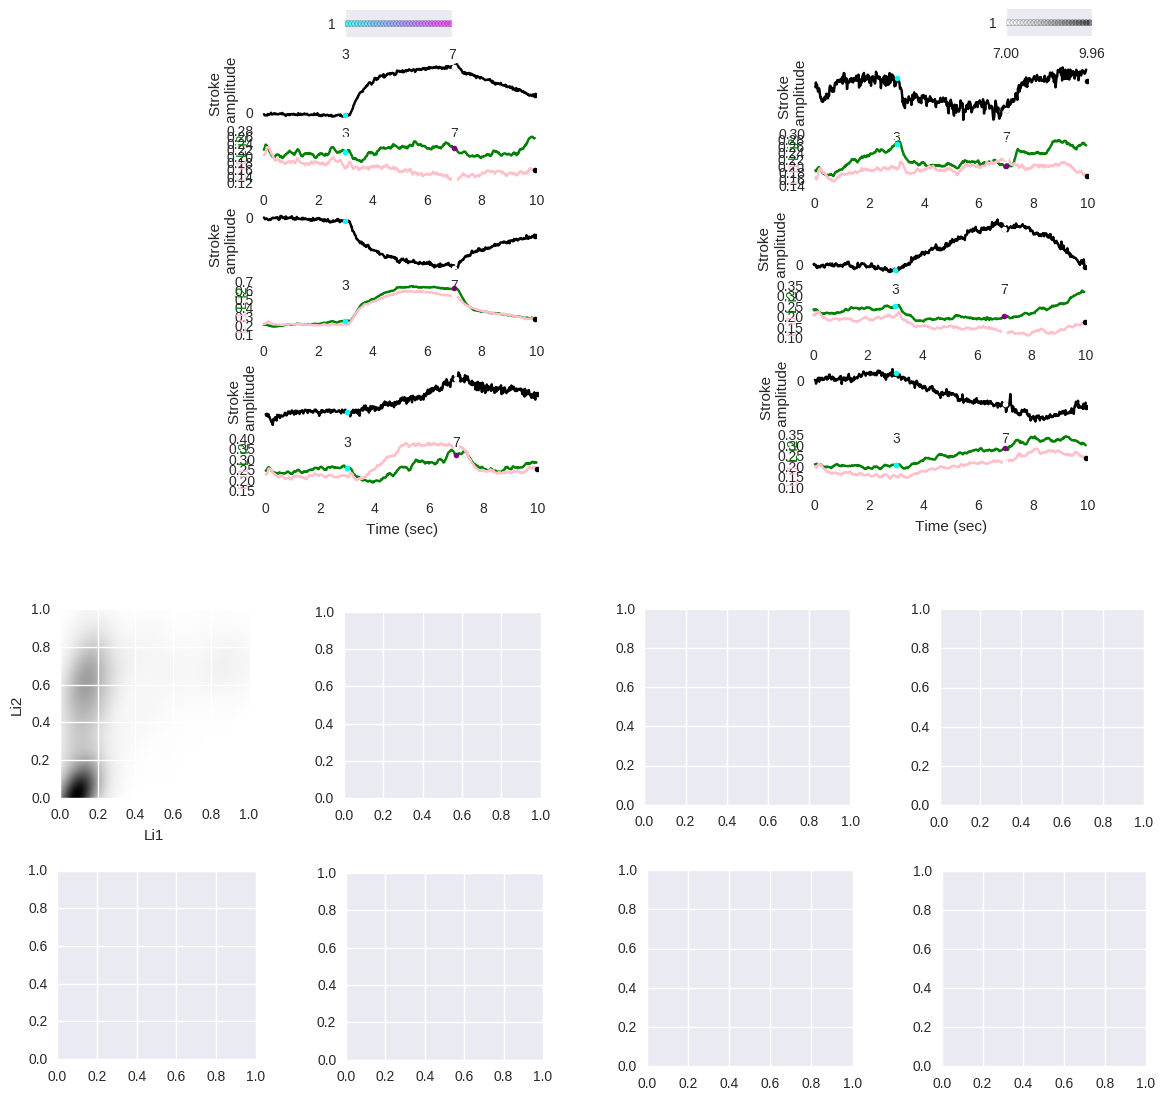

In [48]:

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np; np.random.seed(0)
import pandas as pd
import figurefirst as fifi
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

######TIMING VARIABLES######

start = 1
end = 498

start_stim = 150
end_stim =350

start_decay = 350
end_decay = 498

########MUSCLE NAMING VARIABLES#############

musclea= 'i1_l'
muscleb = 'i2_l'

musclea_name = 'L i1'
muscleb_name = 'L i2'

musclea_scatter = 'Li1'
muscleb_scatter = 'Li2'

###### Y LABELS #############


def multicolor_ylabel(ax, list_of_strings,list_of_colors,axis='y',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="bottom", pad=0, sep=1)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.10, 0.0), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)


########TEMPLATE#############

layout = fifi.FigureLayout('layouts/paper_figure_muscle_by_muscle_min_onset_vs_decay_3.svg',make_mplfigures = True)


########DATA AND PLOTTING#############

fly = flylist[6]
snum = 1  #5


l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]


times = np.arange(500)*0.02
colors = times[150:350]

layout.axes['lmr_rt'].plot(times[start:end],yaw_right_df['mean'][start:end],clip_on = False,color = 'k')
layout.axes['lmr_rt'].set_xbound(0,times[-1])
layout.axes['lmr_rt'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_rt'].patch.set_alpha(0.0)
layout.axes['lmr_rt'].set_ybound(-20,20)
layout.axes['lmr_rt'].set_yticks([-15, 0, 15])
layout.axes['lmr_rt'].plot(times[start_stim],yaw_right_df['mean'][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rt'].plot(times[end_stim],yaw_right_df['mean'][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rt'].plot(times[start_decay],yaw_right_df['mean'][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rt'].plot(times[end_decay],yaw_right_df['mean'][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rt'].set_xticks([times[start_stim],times[end_stim]])


layout.axes['musclea_rt'].plot(times[start:end],yaw_right_df[musclea][start:end],clip_on = False,color = 'green')
layout.axes['musclea_rt'].plot(times[start:end],yaw_right_df[muscleb][start:end],clip_on = False,color = 'pink')
layout.axes['musclea_rt'].set_xbound(0,times[-1])
#layout.axes['musclea_rt'].set_ylabel(musclea_name, color= 'green')
multicolor_ylabel(layout.axes['musclea_rt'], (musclea_name, muscleb_name),('green','pink'),axis='y',size=10)
layout.axes['musclea_rt'].patch.set_alpha(0.0)
layout.axes['musclea_rt'].plot(times[start_stim],yaw_right_df[musclea][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rt'].plot(times[end_stim],yaw_right_df[musclea][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rt'].plot(times[start_decay],yaw_right_df[muscleb][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rt'].plot(times[end_decay],yaw_right_df[muscleb][end_decay],'black', marker='o', markersize=4)#, 'o') 

#_________________________________


layout.axes['lmr_lt'].plot(times[start:end],yaw_left_df['mean'][start:end],clip_on = False,color = 'k')
layout.axes['lmr_lt'].set_xbound(0,times[-1])
layout.axes['lmr_lt'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_lt'].patch.set_alpha(0.0)
layout.axes['lmr_lt'].set_ybound(-20,20)
layout.axes['lmr_lt'].set_yticks([-15, 0, 15])
layout.axes['lmr_lt'].plot(times[start_stim],yaw_left_df['mean'][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_lt'].plot(times[end_stim],yaw_left_df['mean'][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_lt'].plot(times[start_decay],yaw_left_df['mean'][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_lt'].plot(times[end_decay],yaw_left_df['mean'][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_lt'].set_xticks([times[start_stim],times[end_stim]])


layout.axes['musclea_lt'].plot(times[start:end],yaw_left_df[musclea][start:end],clip_on = False,color = 'green')
layout.axes['musclea_lt'].plot(times[start:end],yaw_left_df[muscleb][start:end],clip_on = False,color = 'pink')
layout.axes['musclea_lt'].set_xbound(0,times[-1])
#layout.axes['musclea_lt'].set_ylabel(musclea_name, color= 'green')
multicolor_ylabel(layout.axes['musclea_lt'], (musclea_name, muscleb_name),('green','pink'),axis='y',size=10)
layout.axes['musclea_lt'].patch.set_alpha(0.0)
layout.axes['musclea_lt'].plot(times[start_stim],yaw_left_df[musclea][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_lt'].plot(times[end_stim],yaw_left_df[musclea][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_lt'].plot(times[start_decay],yaw_left_df[muscleb][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_lt'].plot(times[end_decay],yaw_left_df[muscleb][end_decay],'black', marker='o', markersize=4)#, 'o') 

#_________________________________



layout.axes['lmr_pu'].plot(times[start:end],pitch_up_df['mean'][start:end],clip_on = False,color = 'k')
layout.axes['lmr_pu'].set_xbound(0,times[-1])
layout.axes['lmr_pu'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_pu'].patch.set_alpha(0.0)
layout.axes['lmr_pu'].set_ybound(70,80)
layout.axes['lmr_pu'].set_yticks([70, 80])
layout.axes['lmr_pu'].plot(times[start_stim],pitch_up_df['mean'][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pu'].plot(times[end_stim],pitch_up_df['mean'][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pu'].plot(times[start_decay],pitch_up_df['mean'][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pu'].plot(times[end_decay],pitch_up_df['mean'][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pu'].set_xticks([times[start_stim],times[end_stim]])


layout.axes['musclea_pu'].plot(times[start:end],pitch_up_df[musclea][start:end],clip_on = False,color = 'green')
layout.axes['musclea_pu'].plot(times[start:end],pitch_up_df[muscleb][start:end],clip_on = False,color = 'pink')
layout.axes['musclea_pu'].set_xbound(0,times[-1])
#layout.axes['musclea_pu'].set_ylabel(musclea_name, color= 'green')
multicolor_ylabel(layout.axes['musclea_pu'], (musclea_name, muscleb_name),('green','pink'),axis='y',size=10)
layout.axes['musclea_pu'].patch.set_alpha(0.0)
layout.axes['musclea_pu'].plot(times[start_stim],pitch_up_df[musclea][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_pu'].plot(times[end_stim],pitch_up_df[musclea][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_pu'].plot(times[start_decay],pitch_up_df[muscleb][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_pu'].plot(times[end_decay],pitch_up_df[muscleb][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_pu'].set_xlabel('Time (sec)')
#_________________________________



layout.axes['lmr_pd'].plot(times[start:end],pitch_down_df['mean'][start:end],clip_on = False,color = 'k')
layout.axes['lmr_pd'].set_xbound(0,times[-1])
layout.axes['lmr_pd'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_pd'].patch.set_alpha(0.0)
layout.axes['lmr_pd'].set_ybound(70,80)
layout.axes['lmr_pd'].set_yticks([70,80])
layout.axes['lmr_pd'].plot(times[start_stim],pitch_down_df['mean'][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pd'].plot(times[end_stim],pitch_down_df['mean'][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pd'].plot(times[start_decay],pitch_down_df['mean'][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pd'].plot(times[end_decay],pitch_down_df['mean'][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_pd'].set_xticks([times[start_stim],times[end_stim]])


layout.axes['musclea_pd'].plot(times[start:end],pitch_down_df[musclea][start:end],clip_on = False,color = 'green')
layout.axes['musclea_pd'].plot(times[start:end],pitch_down_df[muscleb][start:end],clip_on = False,color = 'pink')
layout.axes['musclea_pd'].set_xbound(0,times[-1])
#layout.axes['musclea_pd'].set_ylabel(musclea_name, color= 'green')
multicolor_ylabel(layout.axes['musclea_pd'], (musclea_name, muscleb_name),('green','pink'),axis='y',size=10)
layout.axes['musclea_pd'].patch.set_alpha(0.0)
layout.axes['musclea_pd'].plot(times[start_stim],pitch_down_df[musclea][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_pd'].plot(times[end_stim],pitch_down_df[musclea][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_pd'].plot(times[start_decay],pitch_down_df[muscleb][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_pd'].plot(times[end_decay],pitch_down_df[muscleb][end_decay],'black', marker='o', markersize=4)#, 'o') 

#_________________________________

layout.axes['lmr_rc'].plot(times[start:end],roll_cw_df['mean'][start:end],clip_on = False,color = 'k')
layout.axes['lmr_rc'].set_xbound(0,times[-1])
layout.axes['lmr_rc'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_rc'].patch.set_alpha(0.0)
layout.axes['lmr_rc'].set_ybound(0,5)
layout.axes['lmr_rc'].set_yticks([0,5])
layout.axes['lmr_rc'].plot(times[start_stim],roll_cw_df['mean'][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rc'].plot(times[end_stim],roll_cw_df['mean'][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rc'].plot(times[start_decay],roll_cw_df['mean'][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rc'].plot(times[end_decay],roll_cw_df['mean'][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rc'].set_xticks([times[start_stim],times[end_stim]])


layout.axes['musclea_rc'].plot(times[start:end],roll_cw_df[musclea][start:end],clip_on = False,color = 'green')
layout.axes['musclea_rc'].plot(times[start:end],roll_cw_df[muscleb][start:end],clip_on = False,color = 'pink')
layout.axes['musclea_rc'].set_xbound(0,times[-1])
#layout.axes['musclea_rc'].set_ylabel(musclea_name, color= 'green')
multicolor_ylabel(layout.axes['musclea_rc'], (musclea_name, muscleb_name),('green','pink'),axis='y',size=10)
layout.axes['musclea_rc'].patch.set_alpha(0.0)
layout.axes['musclea_rc'].plot(times[start_stim],roll_cw_df[musclea][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rc'].plot(times[end_stim],roll_cw_df[musclea][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rc'].plot(times[start_decay],roll_cw_df[muscleb][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rc'].plot(times[end_decay],roll_cw_df[muscleb][end_decay],'black', marker='o', markersize=4)#, 'o') 

#_________________________________

layout.axes['lmr_rcc'].plot(times[start:end],roll_ccw_df['mean'][start:end],clip_on = False,color = 'k')
layout.axes['lmr_rcc'].set_xbound(0,times[-1])
layout.axes['lmr_rcc'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_rcc'].patch.set_alpha(0.0)
layout.axes['lmr_rcc'].set_ybound(-5,0)
layout.axes['lmr_rcc'].set_yticks([-5,0])
layout.axes['lmr_rcc'].plot(times[start_stim],roll_ccw_df['mean'][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rcc'].plot(times[end_stim],roll_ccw_df['mean'][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rcc'].plot(times[start_decay],roll_ccw_df['mean'][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rcc'].plot(times[end_decay],roll_ccw_df['mean'][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rcc'].set_xticks([times[start_stim],times[end_stim]])


layout.axes['musclea_rcc'].plot(times[start:end],roll_ccw_df[musclea][start:end],clip_on = False,color = 'green')
layout.axes['musclea_rcc'].plot(times[start:end],roll_ccw_df[muscleb][start:end],clip_on = False,color = 'pink')
layout.axes['musclea_rcc'].set_xbound(0,times[-1])
#layout.axes['musclea_rcc'].set_ylabel(musclea_name, color= 'green')
multicolor_ylabel(layout.axes['musclea_rcc'], (musclea_name, muscleb_name),('green','pink'),axis='y',size=10)
layout.axes['musclea_rcc'].patch.set_alpha(0.0)
layout.axes['musclea_rcc'].plot(times[start_stim],roll_ccw_df[musclea][start_stim],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rcc'].plot(times[end_stim],roll_ccw_df[musclea][end_stim],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rcc'].plot(times[start_decay],roll_ccw_df[muscleb][start_decay],'white', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rcc'].plot(times[end_decay],roll_ccw_df[muscleb][end_decay],'black', marker='o', markersize=4)#, 'o') 
layout.axes['musclea_rcc'].set_xlabel('Time (sec)')

#_________________________________

x = times[start_stim:end_stim]

ax17 = layout.axes['cmap_legend']
x_prime = x[::6]
y = np.ones(len(x_prime))
colors = x_prime
c = ax17.scatter(x_prime, y, c=colors, cmap='cool', alpha=0.45)
ax17.set_xbound(times[start_stim],times[end_stim]),ax17.set_ybound(0.8,1.2)
ax17.set_xticks([times[start_stim],times[end_stim]])
#ax17.set_xticks([])
#ax17.tick_params(axis=u'none', which=u'none',length=0)
ax17.set_yticks([1])  



x = times[start_decay:end_decay]

ax18 = layout.axes['cmap_legend_decay']
x_prime = x[::6]
y = np.ones(len(x_prime))
colors = x_prime
c = ax18.scatter(x_prime, y, c=colors, cmap='Greys', alpha=0.45)
ax18.set_xbound(times[start_decay],times[end_decay]),ax18.set_ybound(0.8,1.2)
ax18.set_xticks([times[start_decay],times[end_decay]])
#ax17.set_xticks([])
#ax17.tick_params(axis=u'none', which=u'none',length=0)
ax18.set_yticks([1])  


#_________________________________
          
colors = times[start_stim:end_stim]

x = yaw_right_df[musclea][start_stim:end_stim]
y = yaw_right_df[muscleb][start_stim:end_stim]
ax1 = layout.axes['ma_mb']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax1)
c = ax1.scatter(x, y, c=colors, cmap='cool', alpha=0.65)
ax1.set_xbound(0,1),ax1.set_ybound(0,1)
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])  


x = yaw_right_df[musclea][start_stim:end_stim]
y = yaw_right_df[muscleb][start_stim:end_stim]
x1 = yaw_left_df[musclea][start_stim:end_stim]
y1 = yaw_left_df[muscleb][start_stim:end_stim]
x2 = pitch_up_df[musclea][start_stim:end_stim]
y2 = pitch_up_df[muscleb][start_stim:end_stim]
x3 = pitch_down_df[musclea][start_stim:end_stim]
y3 = pitch_down_df[muscleb][start_stim:end_stim]
x4 = roll_cw_df[musclea][start_stim:end_stim]
y4 = roll_cw_df[muscleb][start_stim:end_stim]
x5 = roll_ccw_df[musclea][start_stim:end_stim]
y5 = roll_ccw_df[muscleb][start_stim:end_stim]
ax2 = layout.axes['ma_mb_all']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax2)
c = ax2.scatter(x, y, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x1, y1, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x2, y2, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x3, y3, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x4, y4, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x5, y5, c=colors, cmap='cool', alpha=0.65)
ax2.set_xbound(0,1),ax2.set_ybound(0,1)
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])  




x = yaw_right_df[musclea][start_stim:end_stim]
y = yaw_right_df[muscleb][start_stim:end_stim]
x1 = yaw_left_df[musclea][start_stim:end_stim]
y1 = yaw_left_df[muscleb][start_stim:end_stim]
x2 = pitch_up_df[musclea][start_stim:end_stim]
y2 = pitch_up_df[muscleb][start_stim:end_stim]
x3 = pitch_down_df[musclea][start_stim:end_stim]
y3 = pitch_down_df[muscleb][start_stim:end_stim]
x4 = roll_cw_df[musclea][start_stim:end_stim]
y4 = roll_cw_df[muscleb][start_stim:end_stim]
x5 = roll_ccw_df[musclea][start_stim:end_stim]
y5 = roll_ccw_df[muscleb][start_stim:end_stim]
ax3 = layout.axes['ma_mb_all_inset1']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax3)
c = ax3.scatter(x, y, c=colors, cmap='Reds', alpha=0.65)
c = ax3.scatter(x1, y1, c=colors, cmap='Oranges', alpha=0.65)
c = ax3.scatter(x2, y2, c=colors, cmap='Greens', alpha=0.65)
c = ax3.scatter(x3, y3, c=colors, cmap='Blues', alpha=0.65)
c = ax3.scatter(x4, y4, c=colors, cmap='Purples', alpha=0.65)
c = ax3.scatter(x5, y5, c=colors, cmap='Greys', alpha=0.65)
ax3.set_xbound(0,1),ax3.set_ybound(0,1)
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])  


x = yaw_right_df[musclea][start_stim:end_stim]
y = yaw_right_df[muscleb][start_stim:end_stim]
x1 = yaw_left_df[musclea][start_stim:end_stim]
y1 = yaw_left_df[muscleb][start_stim:end_stim]
x2 = pitch_up_df[musclea][start_stim:end_stim]
y2 = pitch_up_df[muscleb][start_stim:end_stim]
x3 = pitch_down_df[musclea][start_stim:end_stim]
y3 = pitch_down_df[muscleb][start_stim:end_stim]
x4 = roll_cw_df[musclea][start_stim:end_stim]
y4 = roll_cw_df[muscleb][start_stim:end_stim]
x5 = roll_ccw_df[musclea][start_stim:end_stim]
y5 = roll_ccw_df[muscleb][start_stim:end_stim]
ax3 = layout.axes['ma_mb_all_inset2']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax3)
c = ax3.scatter(x, y, c=colors, cmap='Reds', alpha=0.65)
c = ax3.scatter(x1, y1, c=colors, cmap='Oranges', alpha=0.65)
c = ax3.scatter(x2, y2, c=colors, cmap='Greens', alpha=0.65)
c = ax3.scatter(x3, y3, c=colors, cmap='Blues', alpha=0.65)
c = ax3.scatter(x4, y4, c=colors, cmap='Purples', alpha=0.65)
c = ax3.scatter(x5, y5, c=colors, cmap='Greys', alpha=0.65)
ax3.set_xbound(0.3,1),ax3.set_ybound(0.3,1)
ax3.set_xticks([0.1,0.7])
ax3.set_yticks([0.1,0.7])  


#________________________________________________________

colors_decay = times[start_decay:end_decay]
colors = times[start_stim:end_stim]

x = yaw_right_df[musclea][start_decay:end_decay]
y = yaw_right_df[muscleb][start_decay:end_decay]
ax1 = layout.axes['ma_mb_decay']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax1)
c = ax1.scatter(x, y, c=colors_decay, cmap='Greys', alpha=0.65)
ax1.set_xbound(0,1),ax1.set_ybound(0,1)
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])  


x = yaw_right_df[musclea][start_stim:end_stim]
y = yaw_right_df[muscleb][start_stim:end_stim]
x1 = yaw_left_df[musclea][start_stim:end_stim]
y1 = yaw_left_df[muscleb][start_stim:end_stim]
x2 = pitch_up_df[musclea][start_stim:end_stim]
y2 = pitch_up_df[muscleb][start_stim:end_stim]
x3 = pitch_down_df[musclea][start_stim:end_stim]
y3 = pitch_down_df[muscleb][start_stim:end_stim]
x4 = roll_cw_df[musclea][start_stim:end_stim]
y4 = roll_cw_df[muscleb][start_stim:end_stim]
x5 = roll_ccw_df[musclea][start_stim:end_stim]
y5 = roll_ccw_df[muscleb][start_stim:end_stim]
ax2 = layout.axes['ma_mb_all_decay']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax2)
c = ax2.scatter(x, y, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x1, y1, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x2, y2, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x3, y3, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x4, y4, c=colors, cmap='cool', alpha=0.65)
c = ax2.scatter(x5, y5, c=colors, cmap='cool', alpha=0.65)
x = yaw_right_df[musclea][start_decay:end_decay]
y = yaw_right_df[muscleb][start_decay:end_decay]
x1 = yaw_left_df[musclea][start_decay:end_decay]
y1 = yaw_left_df[muscleb][start_decay:end_decay]
x2 = pitch_up_df[musclea][start_decay:end_decay]
y2 = pitch_up_df[muscleb][start_decay:end_decay]
x3 = pitch_down_df[musclea][start_decay:end_decay]
y3 = pitch_down_df[muscleb][start_decay:end_decay]
x4 = roll_cw_df[musclea][start_decay:end_decay]
y4 = roll_cw_df[muscleb][start_decay:end_decay]
x5 = roll_ccw_df[musclea][start_decay:end_decay]
y5 = roll_ccw_df[muscleb][start_decay:end_decay]
c = ax2.scatter(x, y, c=colors_decay, cmap='Greys', alpha=0.65)
c = ax2.scatter(x1, y1, c=colors_decay, cmap='Greys', alpha=0.65)
c = ax2.scatter(x2, y2, c=colors_decay, cmap='Greys', alpha=0.65)
c = ax2.scatter(x3, y3, c=colors_decay, cmap='Greys', alpha=0.65)
c = ax2.scatter(x4, y4, c=colors_decay, cmap='Greys', alpha=0.65)
c = ax2.scatter(x5, y5, c=colors_decay, cmap='Greys', alpha=0.65)
ax2.set_xbound(0,1),ax2.set_ybound(0,1)
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])  



x = yaw_right_df[musclea][start_decay:end_decay]
y = yaw_right_df[muscleb][start_decay:end_decay]
x1 = yaw_left_df[musclea][start_decay:end_decay]
y1 = yaw_left_df[muscleb][start_decay:end_decay]
x2 = pitch_up_df[musclea][start_decay:end_decay]
y2 = pitch_up_df[muscleb][start_decay:end_decay]
x3 = pitch_down_df[musclea][start_decay:end_decay]
y3 = pitch_down_df[muscleb][start_decay:end_decay]
x4 = roll_cw_df[musclea][start_decay:end_decay]
y4 = roll_cw_df[muscleb][start_decay:end_decay]
x5 = roll_ccw_df[musclea][start_decay:end_decay]
y5 = roll_ccw_df[muscleb][start_decay:end_decay]
ax3 = layout.axes['ma_mb_all_inset1_decay']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax3)
c = ax3.scatter(x, y, c=colors_decay, cmap='Reds', alpha=0.65)
c = ax3.scatter(x1, y1, c=colors_decay, cmap='Oranges', alpha=0.65)
c = ax3.scatter(x2, y2, c=colors_decay, cmap='Greens', alpha=0.65)
c = ax3.scatter(x3, y3, c=colors_decay, cmap='Blues', alpha=0.65)
c = ax3.scatter(x4, y4, c=colors_decay, cmap='Purples', alpha=0.65)
c = ax3.scatter(x5, y5, c=colors_decay, cmap='Greys', alpha=0.65)
ax3.set_xbound(0,1),ax3.set_ybound(0,1)
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])  


x = yaw_right_df[musclea][start_decay:end_decay]
y = yaw_right_df[muscleb][start_decay:end_decay]
x1 = yaw_left_df[musclea][start_decay:end_decay]
y1 = yaw_left_df[muscleb][start_decay:end_decay]
x2 = pitch_up_df[musclea][start_decay:end_decay]
y2 = pitch_up_df[muscleb][start_decay:end_decay]
x3 = pitch_down_df[musclea][start_decay:end_decay]
y3 = pitch_down_df[muscleb][start_decay:end_decay]
x4 = roll_cw_df[musclea][start_decay:end_decay]
y4 = roll_cw_df[muscleb][start_decay:end_decay]
x5 = roll_ccw_df[musclea][start_decay:end_decay]
y5 = roll_ccw_df[muscleb][start_decay:end_decay]
ax3 = layout.axes['ma_mb_all_inset2_decay']
scatter(flylist[6], (musclea_scatter),(muscleb_scatter), ax3)
c = ax3.scatter(x, y, c=colors_decay, cmap='Reds', alpha=0.65)
c = ax3.scatter(x1, y1, c=colors_decay, cmap='Oranges', alpha=0.65)
c = ax3.scatter(x2, y2, c=colors_decay, cmap='Greens', alpha=0.65)
c = ax3.scatter(x3, y3, c=colors_decay, cmap='Blues', alpha=0.65)
c = ax3.scatter(x4, y4, c=colors_decay, cmap='Purples', alpha=0.65)
c = ax3.scatter(x5, y5, c=colors_decay, cmap='Greys', alpha=0.65)
ax3.set_xbound(0.3,1),ax3.set_ybound(0.3,1)
ax3.set_xticks([0.1,0.7])
ax3.set_yticks([0.1,0.7])  



### note statistically significant deviations/ excursions from baseline




fifi.mpl_functions.set_spines(layout)
layout.save('figure_05_musclebymuscle_min_Li1_Li2.svg')
plt.close('all')
display(SVG('figure_05_musclebymuscle_min_Li1_Li2.svg'))

In [ ]:
### condfidence intervals scatters, delays 
### interpolation, writing 
### reflected pathways 
### criticality of timing within the sparse motor system
### next look at individual flies and traces 


/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in power


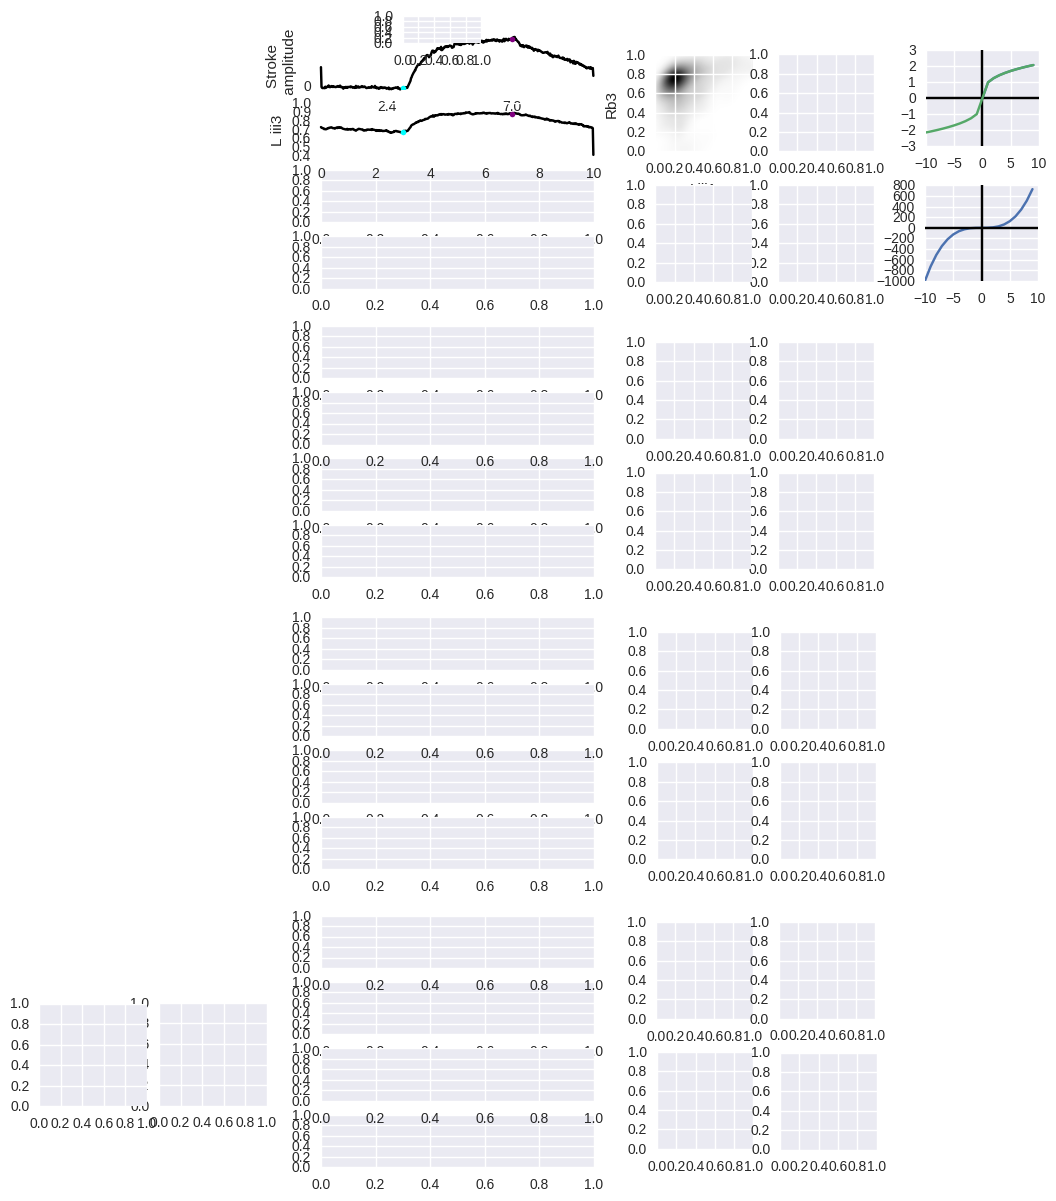

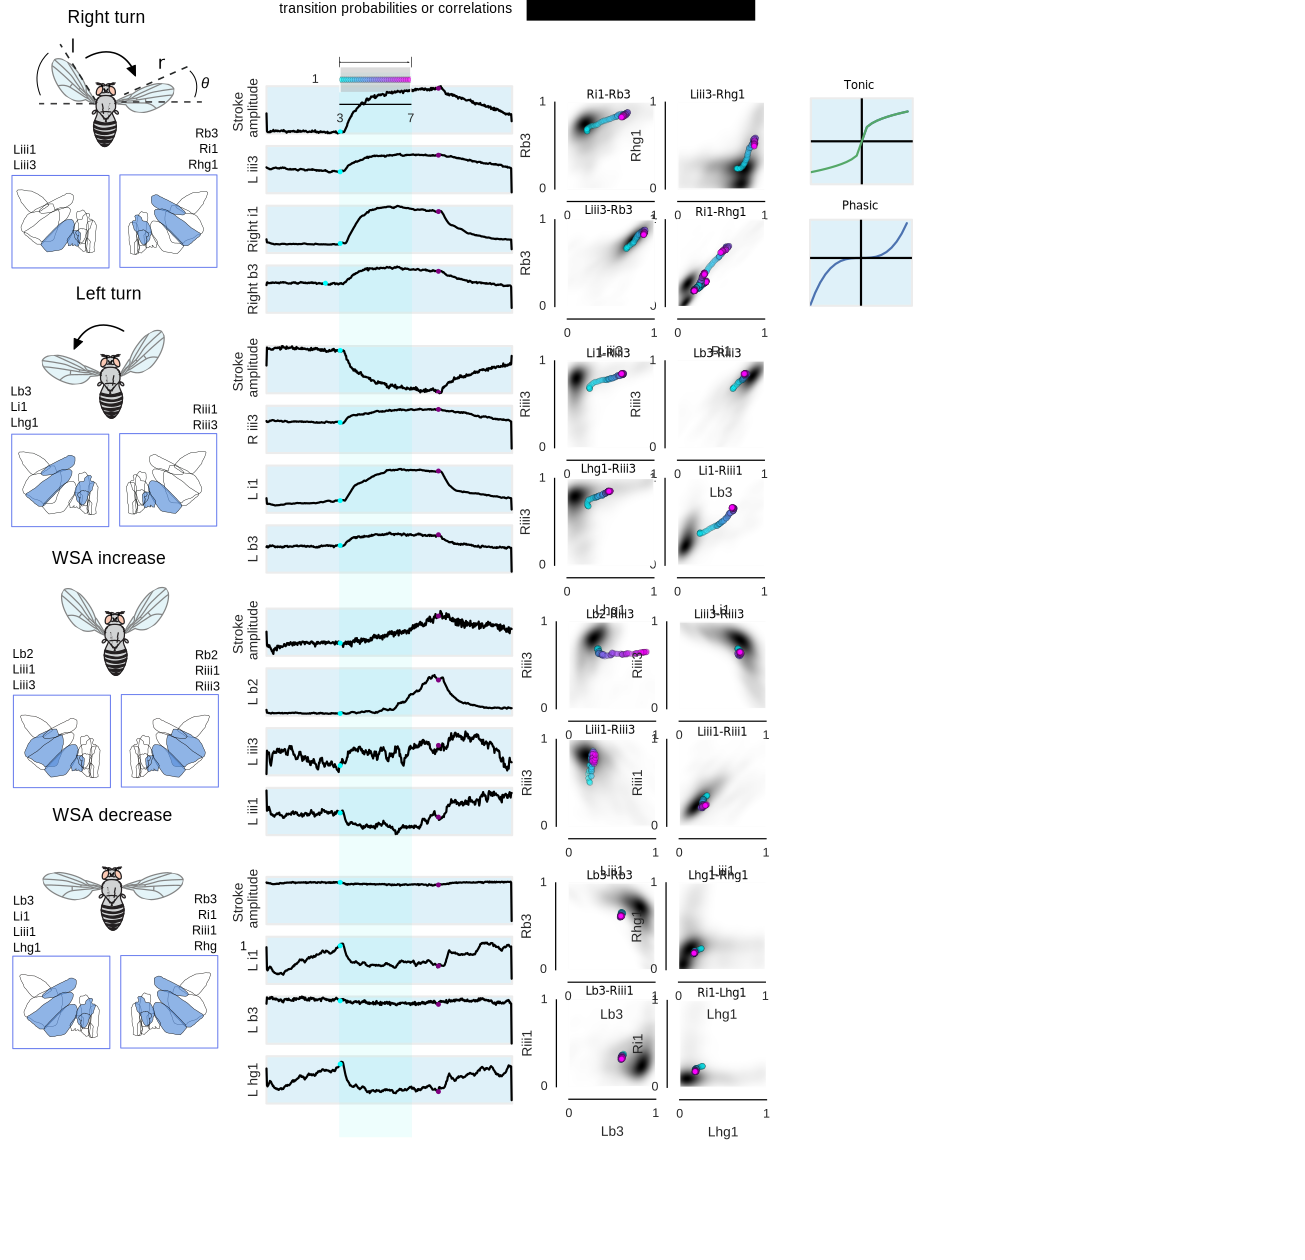

In [116]:
###. Keep this one


from matplotlib.animation import FuncAnimation

import figurefirst as fifi

#layout = fifi.FigureLayout('paper_figure_1_v2.svg',make_mplfigures = True)
layout = fifi.FigureLayout('layouts/paper_figure_4_v8.svg',make_mplfigures = True)

#layout.axes['yaw_left'].plot(time, mean_WBA) #,'o',alpha = 0.2)
#layout.axes['yaw_left'].fill_between(time, (mean_WBA-error), (mean_WBA + error),alpha = 0.1)

#layout.axes['yaw_right'].plot(time, mean_WBA_turn_right) #,'o',alpha = 0.2)
#layout.axes['yaw_right'].fill_between(time, (mean_WBA_turn_right-error_turn_right), (mean_WBA_turn_right + error_turn_right),alpha = 0.1)

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np; np.random.seed(0)
import pandas as pd



x = np.arange(-10,10)
layout.axes['phasic'].plot(x, x**3)
layout.axes['tonic'].plot(x, x** (1. / 3))
layout.axes['phasic'].set_xbound(-10, 10)
layout.axes['tonic'].set_xbound(-10, 10)
layout.axes['tonic'].axhline(y=0, color='k')
layout.axes['tonic'].axvline(x=0, color='k')
layout.axes['phasic'].axhline(y=0, color='k')
layout.axes['phasic'].axvline(x=0, color='k')
#layout.axes['phasic'].set_ybound(-10, 10)
layout.axes['tonic'].set_ybound([-3, 3])
layout.axes['tonic'].plot(x, np.cbrt(x))




fly = flylist[6]
snum = 1  #5

#l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
#r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
#x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
#idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]

l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]


times = np.arange(len(x))*0.02
colors = times[150:350]


x = np.rad2deg(x/10.0 *2*np.pi)
x -= np.mean(x[:100])
x += 180
lmr = np.rad2deg((l-r)/10 *2*np.pi)
l_deg = np.rad2deg((l)/10 *2*np.pi)
r_deg = np.rad2deg((r)/10 *2*np.pi)


###check normed signals method 


times = np.arange(500)*0.02
colors = times[150:350]

layout.axes['lmr_rt'].plot(times,yaw_right_df['mean'],clip_on = False,color = 'k')
layout.axes['lmr_rt'].set_xbound(0,times[-1])
layout.axes['lmr_rt'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_rt'].patch.set_alpha(0.0)
layout.axes['lmr_rt'].set_ybound(-20,20)
layout.axes['lmr_rt'].set_yticks([-15, 0, 15])
layout.axes['lmr_rt'].plot(times[150],yaw_right_df['mean'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_rt'].plot(times[350],yaw_right_df['mean'][350],'purple', marker='o', markersize=4)#, 'o') 
#ax17.set_xbound(times[120],times[350]),ax17.set_ybound(0.8,1.2)
layout.axes['lmr_rt'].set_xticks([times[120],times[350]])


layout.axes['liii1_rt'].plot(times,yaw_right_df['iii3_l'],clip_on = False,color = 'k')
layout.axes['liii1_rt'].set_xbound(0,times[-1])
layout.axes['liii1_rt'].set_ylabel('L iii3')
layout.axes['liii1_rt'].plot(times[150],yaw_right_df['iii3_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['liii1_rt'].patch.set_alpha(0.0)
#layout.axes['liii1_rt'].set_ybound(-20,20)
#layout.axes['liii1_rt'].set_yticks([-15, 0, 15])#
#layout.axes['liii1_rt'].plot(times[120],iii3l[120],'purple', marker='o', markersize=4)#, 'o') 
layout.axes['liii1_rt'].plot(times[350],yaw_right_df['iii3_l'][350],'purple', marker='o', markersize=4)#, 'o') 

#x = list(pitch_down_new_df['muscles'])
c_r = times[150:350]
Min = times[150]
Max = times[350]             
x = yaw_right_df['i1_r'][150:350]
y = yaw_right_df['b3_r'][150:350]
df= pd.DataFrame({"x":x,"y":y,"c":c_r})
cmap = plt.cm.cool
norm = matplotlib.colors.Normalize(vmin=Min, vmax=Max)

ax1 = layout.axes['Liii1_Rb3']
scatter(flylist[6], ('Liii1'),('Rb3'), ax1)
c = ax1.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
#plot_sector(flylist,('left','iii1'),('right','b3'),'nb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
########layout.axes['Liii1_Rb3'].plot(df.x, df.y, color=cmap(norm(df.c.values)), marker = 'o', markersize=2)
#plot_sector(flylist,('left','iii1'),('right','b3'),'lb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
layout.axes['Liii1_Rb3'].set_xbound(0,1),layout.axes['Liii1_Rb3'].set_ybound(0,1)#,ax3.set_xlabel('left b3',color = c_l),ax3.set_ylabel('right b3',color = c_r)
layout.axes['Liii1_Rb3'].set_xticks([0,1])
layout.axes['Liii1_Rb3'].set_yticks([0,1])                

x = yaw_right_df['iii3_l'][150:350]
y = yaw_right_df['hg1_r'][150:350]
ax2 = layout.axes['Liii3_Rhg1']
scatter(flylist[6], ('Liii3'),('Rhg1'), ax2)
c = ax2.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax2.set_xbound(0,1),ax2.set_ybound(0,1)
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])                
                
x = yaw_right_df['iii3_l'][150:350]
y = yaw_right_df['b3_r'][150:350]
ax3 = layout.axes['Liii3_Rb3']
scatter(flylist[6], ('Liii3'),('Rb3'), ax3)
c = ax3.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax3.set_xbound(0,1),ax2.set_ybound(0,1)
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])  


x = yaw_right_df['hg1_r'][150:350]
y = yaw_right_df['i1_r'][150:350]
ax4 = layout.axes['Ri1_Rhg1']
scatter(flylist[6], ('Ri1'),('Rhg1'), ax4)
c = ax4.scatter(x, y, c=colors, cmap='cool', alpha=0.25)

x1 = yaw_left_df['hg1_r'][150:350]
y1 = yaw_left_df['i1_r'][150:350]
#ax4 = layout.axes['Ri1_Rhg1']
scatter(flylist[6], ('Ri1'),('Rhg1'), ax4)
c = ax4.scatter(x1, y1, c=colors, cmap='cool', alpha=0.25)

x2 = pitch_up_df['hg1_r'][150:350]
y2 = pitch_up_df['i1_r'][150:350]
#ax4 = layout.axes['Ri1_Rhg1']
scatter(flylist[6], ('Ri1'),('Rhg1'), ax4)
c = ax4.scatter(x2, y2, c=colors, cmap='cool', alpha=0.25)

x3 = pitch_down_df['hg1_r'][150:350]
y3 = pitch_down_df['i1_r'][150:350]
#ax4 = layout.axes['Ri1_Rhg1']
scatter(flylist[6], ('Ri1'),('Rhg1'), ax4)
c = ax4.scatter(x3, y3, c=colors, cmap='cool', alpha=0.25)

ax4.set_xbound(0,1),ax4.set_ybound(0,1)
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])  



            

layout.axes['ri1_rt'].plot(times,yaw_right_df['i1_r'],clip_on = False,color = 'k')
layout.axes['ri1_rt'].set_xbound(0,times[-1])
layout.axes['ri1_rt'].set_ylabel('Right i1')
layout.axes['ri1_rt'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['ri1_rt'].plot(times[150],yaw_right_df['i1_r'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['ri1_rt'].plot(times[350],yaw_right_df['i1_r'][350],'purple', marker='o', markersize=4)#, 'o') 



layout.axes['rb3_rt'].plot(times,yaw_right_df['b3_r'],clip_on = False,color = 'k')
layout.axes['rb3_rt'].set_xbound(0,times[-1])
layout.axes['rb3_rt'].set_ylabel('Right b3')
layout.axes['rb3_rt'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['rb3_rt'].plot(times[120],yaw_right_df['b3_r'][120],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['rb3_rt'].plot(times[350],yaw_right_df['b3_r'][350],'purple', marker='o', markersize=4)#, 'o') 



#layout.axes['r_wsa'].set_ybound(-15,15)
#layout.axes['r_wsa'].set_yticks([-15,0,15])
#layout.axes['arena_position'].patch.set_alpha(0.0)


##write the clips out here and use the derivative to get the signals 



## plot each segment

#----------------------------------------------------------------------


fly = flylist[6]
snum = 1  #5

l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]
idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]


#l=fly.experimental_block['left', 'amp', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]
#l=fly.experimental_block['right', 'amp', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]
#idxs = fly.experimental_block['common','idx', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]


times = np.arange(500)*0.02

x = np.rad2deg(x/10.0 *2*np.pi)
x -= np.mean(x[:100])
x += 180
lmr = np.rad2deg((l-r)/10 *2*np.pi)
l_deg = np.rad2deg((l)/10 *2*np.pi)
r_deg = np.rad2deg((r)/10 *2*np.pi)

colors = times[150:350]


layout.axes['lmr_lt'].plot(times,yaw_left_df['mean'],clip_on = False,color = 'k')
layout.axes['lmr_lt'].set_xbound(0,times[-1])
layout.axes['lmr_lt'].set_ylabel('Stroke \n amplitude')
layout.axes['lmr_lt'].patch.set_alpha(0.0)
layout.axes['lmr_lt'].set_ybound(-20,20)
layout.axes['lmr_lt'].set_yticks([-15, 0, 15])
#layout.axes['r_wsa'].set_ybound(-15,15)
#layout.axes['r_wsa'].set_yticks([-15,0,15])
#layout.axes['arena_position'].patch.set_alpha(0.0)
layout.axes['lmr_lt'].plot(times[150],yaw_left_df['mean'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lmr_lt'].plot(times[350],yaw_left_df['mean'][350],'purple', marker='o', markersize=4)#, 'o') 


x = yaw_left_df['i1_l'][150:350]
y = yaw_left_df['iii3_r'][150:350]
ax5 = layout.axes['Li1_Riii3']
scatter(flylist[6], ('Li1'),('Riii3'), ax5)
c = ax5.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax5.set_xbound(0,1),ax5.set_ybound(0,1)
ax5.set_xticks([0,1])
ax5.set_yticks([0,1])                
                


x = yaw_left_df['b3_l'][150:350]
y = yaw_left_df['iii3_r'][150:350]
ax6 = layout.axes['Lb3_Riii3']
scatter(flylist[6], ('Lb3'),('Riii3'), ax6)
c = ax6.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax6.set_xbound(0,1),ax6.set_ybound(0,1)
ax6.set_xticks([0,1])
ax6.set_yticks([0,1])                
                               
                
x = yaw_left_df['hg1_l'][150:350]
y = yaw_left_df['iii3_r'][150:350]
ax7 = layout.axes['Lhg1_Riii3']
scatter(flylist[6], ('Lhg1'),('Riii3'), ax7)
c = ax7.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax7.set_xbound(0,1),ax7.set_ybound(0,1)
ax7.set_xticks([0,1])
ax7.set_yticks([0,1])  


x = yaw_left_df['i1_l'][150:350]
y = yaw_left_df['iii1_r'][150:350]
ax8 = layout.axes['Li1_Riii1']
scatter(flylist[6], ('Li1'),('Riii1'), ax8)
c = ax8.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax8.set_xbound(0,1),ax8.set_ybound(0,1)
ax8.set_xticks([0,1])
ax8.set_yticks([0,1])  



layout.axes['riii3_lt'].plot(times,yaw_left_df['iii3_r'],clip_on = False,color = 'k')
layout.axes['riii3_lt'].set_xbound(0,times[-1])
layout.axes['riii3_lt'].set_ylabel('R iii3')
layout.axes['riii3_lt'].patch.set_alpha(0.0)
layout.axes['riii3_lt'].patch.set_alpha(0.0)
#layout.axes['liii1_rt'].set_ybound(-20,20)
#layout.axes['liii1_rt'].set_yticks([-15, 0, 15])#
layout.axes['riii3_lt'].plot(times[150],yaw_left_df['iii3_r'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['riii3_lt'].plot(times[350],yaw_left_df['iii3_r'][350],'purple', marker='o', markersize=4)#, 'o') 


layout.axes['li1_lt'].plot(times,yaw_left_df['i1_l'],clip_on = False,color = 'k')
layout.axes['li1_lt'].set_xbound(0,times[-1])
layout.axes['li1_lt'].set_ylabel('L i1')
layout.axes['li1_lt'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['li1_lt'].plot(times[150],yaw_left_df['i1_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['li1_lt'].plot(times[350],yaw_left_df['i1_l'][350],'purple', marker='o', markersize=4)#, 'o') 

layout.axes['lb3_lt'].plot(times,yaw_left_df['b3_l'],clip_on = False,color = 'k')
layout.axes['lb3_lt'].set_xbound(0,times[-1])
layout.axes['lb3_lt'].set_ylabel('L b3')
layout.axes['lb3_lt'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['lb3_lt'].plot(times[150],yaw_left_df['b3_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lb3_lt'].plot(times[350],yaw_left_df['b3_l'][350],'purple', marker='o', markersize=4)#, 'o') 





#____________________________________________________________________





fly = flylist[3]
snum = 1  #5


l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]
idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]


#l=fly.experimental_block['left', 'amp', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]
#l=fly.experimental_block['right', 'amp', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]
#idxs = fly.experimental_block['common','idx', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]




times = np.arange(500)*0.02

x = np.rad2deg(x/10.0 *2*np.pi)
x -= np.mean(x[:100])
x += 180
lmr = np.rad2deg((l-r)/10 *2*np.pi)
l_deg = np.rad2deg((l)/10 *2*np.pi)
r_deg = np.rad2deg((r)/10 *2*np.pi)
lpr = np.rad2deg((l+r)/10 *2*np.pi)



layout.axes['lpr_WSAi'].plot(times,pitch_up_df['mean'],clip_on = False,color = 'k')
layout.axes['lpr_WSAi'].set_xbound(0,times[-1])
layout.axes['lpr_WSAi'].set_ylabel('Stroke \n amplitude')
layout.axes['lpr_WSAi'].patch.set_alpha(0.0)
#layout.axes['lpr_WSAi'].set_ybound(-20,20)
#layout.axes['lpr_WSAi'].set_yticks([-15, 0, 15])
#layout.axes['r_wsa'].set_ybound(-15,15)
#layout.axes['r_wsa'].set_yticks([-15,0,15])
#layout.axes['arena_position'].patch.set_alpha(0.0)
layout.axes['lpr_WSAi'].plot(times[150],pitch_up_df['mean'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lpr_WSAi'].plot(times[350],pitch_up_df['mean'][350],'purple', marker='o', markersize=4)#, 'o') 




x = pitch_up_df['b2_l'][150:350]
y = pitch_up_df['iii3_r'][150:350]
ax9 = layout.axes['Lb2_Riii3']
scatter(flylist[6], ('Lb2'),('Riii3'), ax9)
c = ax9.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax9.set_xbound(0,1),ax9.set_ybound(0,1)
ax9.set_xticks([0,1])
ax9.set_yticks([0,1])                
                


x = pitch_up_df['iii3_l'][150:350]
y = pitch_up_df['iii3_r'][150:350]
ax10 = layout.axes['Liii3_Riii3']
scatter(flylist[6], ('Liii3'),('Riii3'), ax10)
c = ax10.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax10.set_xbound(0,1),ax10.set_ybound(0,1)
ax10.set_xticks([0,1])
ax10.set_yticks([0,1])                
                               
                
x = iii1l[150:350]
y = iii3r[150:350]
ax11 = layout.axes['Liii1_Riii3']
scatter(flylist[6], ('Liii1'),('Riii3'), ax11)
c = ax11.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax11.set_xbound(0,1),ax11.set_ybound(0,1)
ax11.set_xticks([0,1])
ax11.set_yticks([0,1])  


x = pitch_up_df['iii1_l'][150:350]
y = pitch_up_df['iii1_r'][150:350]
ax12 = layout.axes['Liii1_Riii1']
scatter(flylist[6], ('Liii1'),('Riii1'), ax12)
c = ax12.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax12.set_xbound(0,1),ax12.set_ybound(0,1)
ax12.set_xticks([0,1])
ax12.set_yticks([0,1])  



layout.axes['lb2_WSAi'].plot(times,pitch_up_df['b2_l'],clip_on = False,color = 'k')
layout.axes['lb2_WSAi'].set_xbound(0,times[-1])
layout.axes['lb2_WSAi'].set_ylabel('L b2')
layout.axes['lb2_WSAi'].patch.set_alpha(0.0)
layout.axes['lb2_WSAi'].patch.set_alpha(0.0)
#layout.axes['liii1_rt'].set_ybound(-20,20)
#layout.axes['liii1_rt'].set_yticks([-15, 0, 15])#
layout.axes['lb2_WSAi'].plot(times[150],pitch_up_df['b2_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lb2_WSAi'].plot(times[350],pitch_up_df['b2_l'][350],'purple', marker='o', markersize=4)#, 'o') 


layout.axes['liii3_WSAi'].plot(times,pitch_up_df['iii3_l'],clip_on = False,color = 'k')
layout.axes['liii3_WSAi'].set_xbound(0,times[-1])
layout.axes['liii3_WSAi'].set_ylabel('L iii3')
layout.axes['liii3_WSAi'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['liii3_WSAi'].plot(times[150],pitch_up_df['iii3_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['liii3_WSAi'].plot(times[350],pitch_up_df['iii3_l'][350],'purple', marker='o', markersize=4)#, 'o') 

layout.axes['liii1_WSAi'].plot(times,pitch_up_df['iii1_l'],clip_on = False,color = 'k')
layout.axes['liii1_WSAi'].set_xbound(0,times[-1])
layout.axes['liii1_WSAi'].set_ylabel('L iii1')
layout.axes['liii1_WSAi'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['liii1_WSAi'].plot(times[150],pitch_up_df['iii1_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['liii1_WSAi'].plot(times[350],pitch_up_df['iii1_l'][350],'purple', marker='o', markersize=4)#, 'o') 








#____________________________________________________________________________

fly = flylist[1]
snum = 1  #5

l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]
idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]


#l=fly.experimental_block['left', 'amp', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]
#l=fly.experimental_block['right', 'amp', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]
#idxs = fly.experimental_block['common','idx', 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0'][snum]

times = np.arange(500)*0.02

x = np.rad2deg(x/10.0 *2*np.pi)
x -= np.mean(x[:100])
x += 180
lmr = np.rad2deg((l-r)/10 *2*np.pi)
l_deg = np.rad2deg((l)/10 *2*np.pi)
r_deg = np.rad2deg((r)/10 *2*np.pi)
lpr = np.rad2deg((l+r)/10 *2*np.pi)


layout.axes['lpr_WSAd'].plot(times,pitch_down_df['mean'],clip_on = False,color = 'k')
layout.axes['lpr_WSAd'].set_xbound(0,times[-1])
layout.axes['lpr_WSAd'].set_ylabel('Stroke \n amplitude')
layout.axes['lpr_WSAd'].patch.set_alpha(0.0)
#layout.axes['lpr_WSAd'].set_ybound(-20,20)
#layout.axes['lpr_WSAd'].set_yticks([-15, 0, 15])
#layout.axes['r_wsa'].set_ybound(-15,15)
#layout.axes['r_wsa'].set_yticks([-15,0,15])
#layout.axes['arena_position'].patch.set_alpha(0.0)
layout.axes['lpr_WSAd'].plot(times[150],pitch_down_df['mean'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lpr_WSAd'].plot(times[350],pitch_down_df['mean'][350],'purple', marker='o', markersize=4)#, 'o') 




x = pitch_down_df['b3_l'][150:350]
y = pitch_down_df['b3_r'][150:350]
ax13 = layout.axes['Lb3_Rb3']
scatter(flylist[6], ('Lb3'),('Rb3'), ax13)
c = ax13.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax13.set_xbound(0,1),ax13.set_ybound(0,1)
ax13.set_xticks([0,1])
ax13.set_yticks([0,1])                
                


x = pitch_down_df['hg1_l'][150:350]
y = pitch_down_df['hg1_r'][150:350]
ax14 = layout.axes['Lhg1_Rhg1']
scatter(flylist[6], ('Lhg1'),('Rhg1'), ax14)
c = ax14.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax14.set_xbound(0,1),ax14.set_ybound(0,1)
ax14.set_xticks([0,1])
ax14.set_yticks([0,1])                
                               
                
x = pitch_down_df['b3_l'][150:350]
y = pitch_down_df['iii1_r'][150:350]
ax15 = layout.axes['Lb3_Riii1']
scatter(flylist[6], ('Lb3'),('Riii1'), ax15)
c = ax15.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax15.set_xbound(0,1),ax15.set_ybound(0,1)
ax15.set_xticks([0,1])
ax15.set_yticks([0,1])  


x = pitch_down_df['hg1_l'][150:350]
y = pitch_down_df['i1_r'][150:350]
ax16 = layout.axes['Lhg1_Ri1']
scatter(flylist[6], ('Lhg1'),('Ri1'), ax16)
c = ax16.scatter(x, y, c=colors, cmap='cool', alpha=0.25)
ax16.set_xbound(0,1),ax16.set_ybound(0,1)
ax16.set_xticks([0,1])
ax16.set_yticks([0,1])  


x = times[150:350]

ax17 = layout.axes['cmap_legend']
x_prime = x[::6]
y = np.ones(len(x_prime))
colors = x_prime
c = ax17.scatter(x_prime, y, c=colors, cmap='cool', alpha=0.45)
ax17.set_xbound(times[150],times[350]),ax17.set_ybound(0.8,1.2)
ax17.set_xticks([times[150],times[350]])
#ax17.set_xticks([])
#ax17.tick_params(axis=u'none', which=u'none',length=0)
ax17.set_yticks([1])  



layout.axes['li1_WSAd'].plot(times,pitch_down_df['i1_l'],clip_on = False,color = 'k')
layout.axes['li1_WSAd'].set_xbound(0,times[-1])
layout.axes['li1_WSAd'].set_ylabel('L i1')
layout.axes['li1_WSAd'].patch.set_alpha(0.0)
layout.axes['li1_WSAd'].patch.set_alpha(0.0)
#layout.axes['liii1_rt'].set_ybound(-20,20)
#layout.axes['liii1_rt'].set_yticks([-15, 0, 15])#
layout.axes['li1_WSAd'].plot(times[150],pitch_down_df['i1_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['li1_WSAd'].plot(times[350],pitch_down_df['i1_l'][350],'purple', marker='o', markersize=4)#, 'o') 


layout.axes['lb3_WSAd'].plot(times,pitch_down_df['b3_l'],clip_on = False,color = 'k')
layout.axes['lb3_WSAd'].set_xbound(0,times[-1])
layout.axes['lb3_WSAd'].set_ylabel('L b3')
layout.axes['lb3_WSAd'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['lb3_WSAd'].plot(times[150],pitch_down_df['b3_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lb3_WSAd'].plot(times[350],pitch_down_df['b3_l'][350],'purple', marker='o', markersize=4)#, 'o') 

layout.axes['lhg1_WSAd'].plot(times,pitch_down_df['hg1_l'],clip_on = False,color = 'k')
layout.axes['lhg1_WSAd'].set_xbound(0,times[-1])
layout.axes['lhg1_WSAd'].set_ylabel('L hg1')
layout.axes['lhg1_WSAd'].patch.set_alpha(0.0)
#layout.axes['ri1_rt'].set_ybound(-20,20)
#layout.axes['ri1_rt'].set_yticks([-15, 0, 15])
layout.axes['lhg1_WSAd'].plot(times[150],pitch_down_df['hg1_l'][150],'cyan', marker='o', markersize=4)#, 'o') 
layout.axes['lhg1_WSAd'].plot(times[350],pitch_down_df['hg1_l'][350],'purple', marker='o', markersize=4)#, 'o') 







fifi.mpl_functions.set_spines(layout)
layout.save('figure_05_revised_v2_kde.svg')
plt.close('all')
display(SVG('figure_05_revised_v2_kde.svg'))

In [55]:
df = pd.read_csv('fly_4_yr_mean.csv')

In [57]:
df['mean']= df['amp_diff']

In [58]:
yaw_left_df = df

In [61]:
df = pd.read_csv('fly_4_yl_mean.csv')
df['mean']= df['amp_diff']
yaw_right_df = df

In [62]:
df = pd.read_csv('fly_4_pu_mean.csv')
df['mean']= df['amp_diff']
pitch_up_df = df

In [63]:
df = pd.read_csv('fly_4_pd_mean.csv')
df['mean']= df['amp_diff']
pitch_down_df = df

In [53]:
df.columns

Index([u'c', u'x', u'y'], dtype='object')

In [56]:
df.head()

Unnamed: 0  Unnamed: 0.1            t  amp_diff  left_amp  right_amp  \
0           0        187327  1062.557798  0.254668  0.883954   0.646264   
1           1        187328  1062.577799  0.271646  0.900932   0.629286   
2           2        187329  1062.597799  0.271646  0.900932   0.646264   
3           3        187330  1062.617799  0.254668  0.900932   0.646264   
4           4        187331  1062.637800  0.254668  0.900932   0.646264   

   fly_num    wbf   pr_left  tpd_left  ...    hg1_right  i1_right  bkg_right  \
0        4  177.0  0.345653  0.396704  ...     0.195204  0.750745   0.403743   
1        4  177.0  0.336974  0.410865  ...     0.193320  0.807449   0.405467   
2        4  177.0  0.333032  0.416870  ...     0.186173  0.845723   0.413561   
3        4  177.0  0.377197  0.440042  ...     0.195008  0.864594   0.425851   
4        4  177.0  0.196274  0.335483  ...     0.169645  0.723240   0.254222   

   b1_right  b2_right  b3_right  iii24_right  hg4_right  l_plus_r  trial  
0  0.518233       0.0  0.832303          NaN        NaN  1.524559      8  
1  0.493024       0.0  0.858494          NaN        NaN  1.524559      8  
2  0.451913       0.0  0.849445          NaN        NaN  1.547196      8  
3  0.461701       0.0  0.849263          NaN        NaN  1.547196      8  
4  0.412937       0.0  0.748771          NaN        NaN  1.547196      8  

[5 rows x 42 columns]

In [ ]:
yaw_right
yaw_left
pitch_up
pitch_down
roll_cw
roll_ccw


In [26]:
yaw_left = multi_fly_df.loc[multi_fly_df['stimulus']== 'yaw_left, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
yaw_right = multi_fly_df.loc[multi_fly_df['stimulus']== 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
pitch_up = multi_fly_df.loc[multi_fly_df['stimulus']== 'pitch_up_actually_roll, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
pitch_down = multi_fly_df.loc[multi_fly_df['stimulus']== 'pitch_down_actually_roll, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
roll_cw = multi_fly_df.loc[multi_fly_df['stimulus']== 'roll_clockwise_actually_pitch, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
roll_ccw = multi_fly_df.loc[multi_fly_df['stimulus']== 'roll_counterclockwise_actually_pitch, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']



In [59]:
yaw_left_a = yaw_left.loc[yaw_left['experimental_condition']== 'condition=test']
yaw_right_a = yaw_right.loc[yaw_right['experimental_condition']== 'condition=test']
pitch_up_a = pitch_up.loc[pitch_up['experimental_condition']== 'condition=test']
pitch_down_a = pitch_down.loc[pitch_down['experimental_condition']== 'condition=test']
roll_cw_a = roll_cw.loc[roll_cw['experimental_condition']== 'condition=test']
roll_ccw_a = roll_ccw.loc[roll_ccw['experimental_condition']== 'condition=test']




In [27]:

####Yaw right

repeats = range(3)
i = 0

db1l = pd.DataFrame()
db1r= pd.DataFrame()
db2l=pd.DataFrame()
db2r=pd.DataFrame()
db3l=pd.DataFrame()
db3r=pd.DataFrame()
di1l=pd.DataFrame()
di1r=pd.DataFrame()
di2l=pd.DataFrame()
di2r=pd.DataFrame()
diii1l= pd.DataFrame()
diii1r=pd.DataFrame()
diii3l=pd.DataFrame()
diii3r=pd.DataFrame()
dhg1l=pd.DataFrame()
dhg1r=pd.DataFrame()
dhg2l=pd.DataFrame()
dhg2r=pd.DataFrame()
dhg3l=pd.DataFrame()
dhg3r=pd.DataFrame()
dhg4l=pd.DataFrame()
dhg4r=pd.DataFrame()
dlmr= pd.DataFrame()

for fly in flylist:
    for snum in repeats:
        
        l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        
        b1l = normd(fly.normed_signals['left', 'b1'])[idxs]
        b1r = normd(fly.normed_signals['right', 'b1'])[idxs]

        b2l = normd(fly.normed_signals['left', 'b2'])[idxs]
        b2r = normd(fly.normed_signals['right', 'b2'])[idxs]

        b3l = normd(fly.normed_signals['left', 'b3'])[idxs]
        b3r = normd(fly.normed_signals['right', 'b3'])[idxs]

        i1l = normd(fly.normed_signals['left', 'i1'])[idxs]
        i1r = normd(fly.normed_signals['right', 'i1'])[idxs]

        i2l = normd(fly.normed_signals['left', 'i2'])[idxs]
        i2r = normd(fly.normed_signals['right', 'i2'])[idxs]

        iii1l = normd(fly.normed_signals['left', 'iii1'])[idxs]
        iii1r = normd(fly.normed_signals['right', 'iii1'])[idxs]

        iii3l = normd(fly.normed_signals['left', 'iii3'])[idxs]
        iii3r = normd(fly.normed_signals['right', 'iii3'])[idxs]

        hg1l = normd(fly.normed_signals['left', 'hg1'])[idxs]
        hg1r = normd(fly.normed_signals['right', 'hg1'])[idxs]

        hg2l = normd(fly.normed_signals['left', 'hg2'])[idxs]
        hg2r = normd(fly.normed_signals['right', 'hg2'])[idxs]

        hg3l = normd(fly.normed_signals['left', 'hg3'])[idxs]
        hg3r = normd(fly.normed_signals['right', 'hg3'])[idxs]

        hg4l = normd(fly.normed_signals['left', 'hg4'])[idxs]
        hg4r = normd(fly.normed_signals['right', 'hg4'])[idxs]
        
        lmr_prime = np.rad2deg((l-r)/10 *2*np.pi)
        
        
        db1l[i] = b1l
        db1r[i]= b1r
        db2l[i]=b2l
        db2r[i]=b2r
        db3l[i]=b3l
        db3r[i]=b3r
        di1l[i]=i1l
        di1r[i]=i1r
        di2l[i]=i2l
        di2r[i]=i2r
        diii1l[i]= iii1l
        diii1r[i]=iii1r
        diii3l[i]=iii3l
        diii3r[i]=iii3r
        dhg1l[i]=hg1l
        dhg1r[i]=hg1r
        dhg2l[i]=hg2l
        dhg2r[i]=hg2r
        dhg3l[i]=hg3l
        dhg3r[i]=hg3r
        dhg4l[i]=hg4l
        dhg4r[i]=hg4r
        dlmr[i] = lmr_prime
        
        i+= 1

db1l = db1l.fillna(0)
db1r= db1r.fillna(0)
db2l=db2l.fillna(0)
db2r=db2r.fillna(0)
db3l=db3l.fillna(0)
db3r=db3r.fillna(0)
di1l=di1l.fillna(0)
di1r=di1r.fillna(0)
di2l=di2l.fillna(0)
di2r=di2r.fillna(0)
diii1l= diii1l.fillna(0)
diii1r=diii1r.fillna(0)
diii3l=diii3l.fillna(0)
diii3r=diii3r.fillna(0)
dhg1l=dhg1l.fillna(0)
dhg1r=dhg1r.fillna(0)
dhg2l=dhg2l.fillna(0)
dhg2r=dhg2r.fillna(0)
dhg3l=dhg3l.fillna(0)
dhg3r=dhg3r.fillna(0)
dhg4l=dhg4l.fillna(0)
dhg4r=dhg4r.fillna(0)
dlmr= dlmr.fillna(0)

yaw_right_db1l = db1l.mean(axis = 1)
yaw_right_db1r= db1r.mean(axis = 1)
yaw_right_db2l=db2l.mean(axis = 1)
yaw_right_db2r=db2r.mean(axis = 1)
yaw_right_db3l=db3l.mean(axis = 1)
yaw_right_db3r=db3r.mean(axis = 1)
yaw_right_di1l=di1l.mean(axis = 1)
yaw_right_di1r=di1r.mean(axis = 1)
yaw_right_di2l=di2l.mean(axis = 1)
yaw_right_di2r=di2r.mean(axis = 1)
yaw_right_diii1l= diii1l.mean(axis = 1)
yaw_right_diii1r=diii1r.mean(axis = 1)
yaw_right_diii3l=diii3l.mean(axis = 1)
yaw_right_diii3r=diii3r.mean(axis = 1)
yaw_right_dhg1l=dhg1l.mean(axis = 1)
yaw_right_dhg1r=dhg1r.mean(axis = 1)
yaw_right_dhg2l=dhg2l.mean(axis = 1)
yaw_right_dhg2r=dhg2r.mean(axis = 1)
yaw_right_dhg3l=dhg3l.mean(axis = 1)
yaw_right_dhg3r=dhg3r.mean(axis = 1)
yaw_right_dhg4l=dhg4l.mean(axis = 1)
yaw_right_dhg4r=dhg4r.mean(axis = 1)
yaw_right_dlmr= dlmr.mean(axis=1)

yaw_right_db1l_er = db1l.std(axis = 1)
yaw_right_db1r_er= db1r.std(axis = 1)
yaw_right_db2l_er=db2l.std(axis = 1)
yaw_right_db2r_er=db2r.std(axis = 1)
yaw_right_db3l_er=db3l.std(axis = 1)
yaw_right_db3r_er=db3r.std(axis = 1)
yaw_right_di1l_er=di1l.std(axis = 1)
yaw_right_di1r_er=di1r.std(axis = 1)
yaw_right_di2l_er=di2l.std(axis = 1)
yaw_right_di2r_er=di2r.std(axis = 1)
yaw_right_diii1l_er= diii1l.std(axis = 1)
yaw_right_diii1r_er=diii1r.std(axis = 1)
yaw_right_diii3l_er=diii3l.std(axis = 1)
yaw_right_diii3r_er=diii3r.std(axis = 1)
yaw_right_dhg1l_er=dhg1l.std(axis = 1)
yaw_right_dhg1r_er=dhg1r.std(axis = 1)
yaw_right_dhg2l_er=dhg2l.std(axis = 1)
yaw_right_dhg2r_er=dhg2r.std(axis = 1)
yaw_right_dhg3l_er=dhg3l.std(axis = 1)
yaw_right_dhg3r_er=dhg3r.std(axis = 1)
yaw_right_dhg4l_er=dhg4l.std(axis = 1)
yaw_right_dhg4r_er=dhg4r.std(axis = 1)
yaw_right_dlmr_er= dlmr.std(axis=1)


/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [48]:
yaw_right_dhg4r_er.head()

0    0.229175
1    0.224203
2    0.226475
3    0.227547
4    0.226930
dtype: float64

In [28]:

####Yaw left

repeats = range(3)
i = 0

db1l = pd.DataFrame()
db1r= pd.DataFrame()
db2l=pd.DataFrame()
db2r=pd.DataFrame()
db3l=pd.DataFrame()
db3r=pd.DataFrame()
di1l=pd.DataFrame()
di1r=pd.DataFrame()
di2l=pd.DataFrame()
di2r=pd.DataFrame()
diii1l= pd.DataFrame()
diii1r=pd.DataFrame()
diii3l=pd.DataFrame()
diii3r=pd.DataFrame()
dhg1l=pd.DataFrame()
dhg1r=pd.DataFrame()
dhg2l=pd.DataFrame()
dhg2r=pd.DataFrame()
dhg3l=pd.DataFrame()
dhg3r=pd.DataFrame()
dhg4l=pd.DataFrame()
dhg4r=pd.DataFrame()
dlmr= pd.DataFrame()

for fly in flylist:
    for snum in repeats:
        
        l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]
        r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]
        x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]
        idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'][snum]
        
        b1l = normd(fly.normed_signals['left', 'b1'])[idxs]
        b1r = normd(fly.normed_signals['right', 'b1'])[idxs]

        b2l = normd(fly.normed_signals['left', 'b2'])[idxs]
        b2r = normd(fly.normed_signals['right', 'b2'])[idxs]

        b3l = normd(fly.normed_signals['left', 'b3'])[idxs]
        b3r = normd(fly.normed_signals['right', 'b3'])[idxs]

        i1l = normd(fly.normed_signals['left', 'i1'])[idxs]
        i1r = normd(fly.normed_signals['right', 'i1'])[idxs]

        i2l = normd(fly.normed_signals['left', 'i2'])[idxs]
        i2r = normd(fly.normed_signals['right', 'i2'])[idxs]

        iii1l = normd(fly.normed_signals['left', 'iii1'])[idxs]
        iii1r = normd(fly.normed_signals['right', 'iii1'])[idxs]

        iii3l = normd(fly.normed_signals['left', 'iii3'])[idxs]
        iii3r = normd(fly.normed_signals['right', 'iii3'])[idxs]

        hg1l = normd(fly.normed_signals['left', 'hg1'])[idxs]
        hg1r = normd(fly.normed_signals['right', 'hg1'])[idxs]

        hg2l = normd(fly.normed_signals['left', 'hg2'])[idxs]
        hg2r = normd(fly.normed_signals['right', 'hg2'])[idxs]

        hg3l = normd(fly.normed_signals['left', 'hg3'])[idxs]
        hg3r = normd(fly.normed_signals['right', 'hg3'])[idxs]

        hg4l = normd(fly.normed_signals['left', 'hg4'])[idxs]
        hg4r = normd(fly.normed_signals['right', 'hg4'])[idxs]
        
        lmr_prime = np.rad2deg((l-r)/10 *2*np.pi)
        
        
        db1l[i] = b1l
        db1r[i]= b1r
        db2l[i]=b2l
        db2r[i]=b2r
        db3l[i]=b3l
        db3r[i]=b3r
        di1l[i]=i1l
        di1r[i]=i1r
        di2l[i]=i2l
        di2r[i]=i2r
        diii1l[i]= iii1l
        diii1r[i]=iii1r
        diii3l[i]=iii3l
        diii3r[i]=iii3r
        dhg1l[i]=hg1l
        dhg1r[i]=hg1r
        dhg2l[i]=hg2l
        dhg2r[i]=hg2r
        dhg3l[i]=hg3l
        dhg3r[i]=hg3r
        dhg4l[i]=hg4l
        dhg4r[i]=hg4r
        dlmr[i] = lmr_prime
        
        i+= 1

db1l = db1l.fillna(0)
db1r= db1r.fillna(0)
db2l=db2l.fillna(0)
db2r=db2r.fillna(0)
db3l=db3l.fillna(0)
db3r=db3r.fillna(0)
di1l=di1l.fillna(0)
di1r=di1r.fillna(0)
di2l=di2l.fillna(0)
di2r=di2r.fillna(0)
diii1l= diii1l.fillna(0)
diii1r=diii1r.fillna(0)
diii3l=diii3l.fillna(0)
diii3r=diii3r.fillna(0)
dhg1l=dhg1l.fillna(0)
dhg1r=dhg1r.fillna(0)
dhg2l=dhg2l.fillna(0)
dhg2r=dhg2r.fillna(0)
dhg3l=dhg3l.fillna(0)
dhg3r=dhg3r.fillna(0)
dhg4l=dhg4l.fillna(0)
dhg4r=dhg4r.fillna(0)
dlmr= dlmr.fillna(0)

yaw_left_db1l = db1l.mean(axis = 1)
yaw_left_db1r= db1r.mean(axis = 1)
yaw_left_db2l=db2l.mean(axis = 1)
yaw_left_db2r=db2r.mean(axis = 1)
yaw_left_db3l=db3l.mean(axis = 1)
yaw_left_db3r=db3r.mean(axis = 1)
yaw_left_di1l=di1l.mean(axis = 1)
yaw_left_di1r=di1r.mean(axis = 1)
yaw_left_di2l=di2l.mean(axis = 1)
yaw_left_di2r=di2r.mean(axis = 1)
yaw_left_diii1l= diii1l.mean(axis = 1)
yaw_left_diii1r=diii1r.mean(axis = 1)
yaw_left_diii3l=diii3l.mean(axis = 1)
yaw_left_diii3r=diii3r.mean(axis = 1)
yaw_left_dhg1l=dhg1l.mean(axis = 1)
yaw_left_dhg1r=dhg1r.mean(axis = 1)
yaw_left_dhg2l=dhg2l.mean(axis = 1)
yaw_left_dhg2r=dhg2r.mean(axis = 1)
yaw_left_dhg3l=dhg3l.mean(axis = 1)
yaw_left_dhg3r=dhg3r.mean(axis = 1)
yaw_left_dhg4l=dhg4l.mean(axis = 1)
yaw_left_dhg4r=dhg4r.mean(axis = 1)
yaw_left_dlmr= dlmr.mean(axis=1)


yaw_left_db1l_er = db1l.std(axis = 1)
yaw_left_db1r_er= db1r.std(axis = 1)
yaw_left_db2l_er=db2l.std(axis = 1)
yaw_left_db2r_er=db2r.std(axis = 1)
yaw_left_db3l_er=db3l.std(axis = 1)
yaw_left_db3r_er=db3r.std(axis = 1)
yaw_left_di1l_er=di1l.std(axis = 1)
yaw_left_di1r_er=di1r.std(axis = 1)
yaw_left_di2l_er=di2l.std(axis = 1)
yaw_left_di2r_er=di2r.std(axis = 1)
yaw_left_diii1l_er= diii1l.std(axis = 1)
yaw_left_diii1r_er=diii1r.std(axis = 1)
yaw_left_diii3l_er=diii3l.std(axis = 1)
yaw_left_diii3r_er=diii3r.std(axis = 1)
yaw_left_dhg1l_er=dhg1l.std(axis = 1)
yaw_left_dhg1r_er=dhg1r.std(axis = 1)
yaw_left_dhg2l_er=dhg2l.std(axis = 1)
yaw_left_dhg2r_er=dhg2r.std(axis = 1)
yaw_left_dhg3l_er=dhg3l.std(axis = 1)
yaw_left_dhg3r_er=dhg3r.std(axis = 1)
yaw_left_dhg4l_er=dhg4l.std(axis = 1)
yaw_left_dhg4r_er=dhg4r.std(axis = 1)
yaw_left_dlmr_er= dlmr.std(axis=1)


/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [62]:
l = fly.block_data['left', 'amp', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]
idxs = fly.block_data['common','idx', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
fly.block_data['left', 'amp', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]

In [29]:

####WSA increase

repeats = range(3)
i = 0

db1l = pd.DataFrame()
db1r= pd.DataFrame()
db2l=pd.DataFrame()
db2r=pd.DataFrame()
db3l=pd.DataFrame()
db3r=pd.DataFrame()
di1l=pd.DataFrame()
di1r=pd.DataFrame()
di2l=pd.DataFrame()
di2r=pd.DataFrame()
diii1l= pd.DataFrame()
diii1r=pd.DataFrame()
diii3l=pd.DataFrame()
diii3r=pd.DataFrame()
dhg1l=pd.DataFrame()
dhg1r=pd.DataFrame()
dhg2l=pd.DataFrame()
dhg2r=pd.DataFrame()
dhg3l=pd.DataFrame()
dhg3r=pd.DataFrame()
dhg4l=pd.DataFrame()
dhg4r=pd.DataFrame()
dlmr= pd.DataFrame()

for fly in flylist:
    for snum in repeats:
        
        #l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]
        #r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]
        #x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]
        #idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'][snum]
        
        #ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0
        
        l = fly.block_data['left', 'amp', 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0'][snum]
        r = fly.block_data['right', 'amp', 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0'][snum]
        x = fly.block_data['common', 'x_pos', 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0'][snum]
        idxs = fly.block_data['common','idx', 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0'][snum]
        
        
        b1l = normd(fly.normed_signals['left', 'b1'])[idxs]
        b1r = normd(fly.normed_signals['right', 'b1'])[idxs]

        b2l = normd(fly.normed_signals['left', 'b2'])[idxs]
        b2r = normd(fly.normed_signals['right', 'b2'])[idxs]

        b3l = normd(fly.normed_signals['left', 'b3'])[idxs]
        b3r = normd(fly.normed_signals['right', 'b3'])[idxs]

        i1l = normd(fly.normed_signals['left', 'i1'])[idxs]
        i1r = normd(fly.normed_signals['right', 'i1'])[idxs]

        i2l = normd(fly.normed_signals['left', 'i2'])[idxs]
        i2r = normd(fly.normed_signals['right', 'i2'])[idxs]

        iii1l = normd(fly.normed_signals['left', 'iii1'])[idxs]
        iii1r = normd(fly.normed_signals['right', 'iii1'])[idxs]

        iii3l = normd(fly.normed_signals['left', 'iii3'])[idxs]
        iii3r = normd(fly.normed_signals['right', 'iii3'])[idxs]

        hg1l = normd(fly.normed_signals['left', 'hg1'])[idxs]
        hg1r = normd(fly.normed_signals['right', 'hg1'])[idxs]

        hg2l = normd(fly.normed_signals['left', 'hg2'])[idxs]
        hg2r = normd(fly.normed_signals['right', 'hg2'])[idxs]

        hg3l = normd(fly.normed_signals['left', 'hg3'])[idxs]
        hg3r = normd(fly.normed_signals['right', 'hg3'])[idxs]

        hg4l = normd(fly.normed_signals['left', 'hg4'])[idxs]
        hg4r = normd(fly.normed_signals['right', 'hg4'])[idxs]
        
        lmr_prime = np.rad2deg((l+r)/10 *2*np.pi)
        
        db1l[i] = b1l
        db1r[i]= b1r
        db2l[i]=b2l
        db2r[i]=b2r
        db3l[i]=b3l
        db3r[i]=b3r
        di1l[i]=i1l
        di1r[i]=i1r
        di2l[i]=i2l
        di2r[i]=i2r
        diii1l[i]= iii1l
        diii1r[i]=iii1r
        diii3l[i]=iii3l
        diii3r[i]=iii3r
        dhg1l[i]=hg1l
        dhg1r[i]=hg1r
        dhg2l[i]=hg2l
        dhg2r[i]=hg2r
        dhg3l[i]=hg3l
        dhg3r[i]=hg3r
        dhg4l[i]=hg4l
        dhg4r[i]=hg4r
        dlmr[i] = lmr_prime
        
        i+= 1

db1l = db1l.fillna(0)
db1r= db1r.fillna(0)
db2l=db2l.fillna(0)
db2r=db2r.fillna(0)
db3l=db3l.fillna(0)
db3r=db3r.fillna(0)
di1l=di1l.fillna(0)
di1r=di1r.fillna(0)
di2l=di2l.fillna(0)
di2r=di2r.fillna(0)
diii1l= diii1l.fillna(0)
diii1r=diii1r.fillna(0)
diii3l=diii3l.fillna(0)
diii3r=diii3r.fillna(0)
dhg1l=dhg1l.fillna(0)
dhg1r=dhg1r.fillna(0)
dhg2l=dhg2l.fillna(0)
dhg2r=dhg2r.fillna(0)
dhg3l=dhg3l.fillna(0)
dhg3r=dhg3r.fillna(0)
dhg4l=dhg4l.fillna(0)
dhg4r=dhg4r.fillna(0)
dlmr= dlmr.fillna(0)

WSAi_db1l = db1l.mean(axis = 1)
WSAi_db1r= db1r.mean(axis = 1)
WSAi_db2l=db2l.mean(axis = 1)
WSAi_db2r=db2r.mean(axis = 1)
WSAi_db3l=db3l.mean(axis = 1)
WSAi_db3r=db3r.mean(axis = 1)
WSAi_di1l=di1l.mean(axis = 1)
WSAi_di1r=di1r.mean(axis = 1)
WSAi_di2l=di2l.mean(axis = 1)
WSAi_di2r=di2r.mean(axis = 1)
WSAi_diii1l= diii1l.mean(axis = 1)
WSAi_diii1r=diii1r.mean(axis = 1)
WSAi_diii3l=diii3l.mean(axis = 1)
WSAi_diii3r=diii3r.mean(axis = 1)
WSAi_dhg1l=dhg1l.mean(axis = 1)
WSAi_dhg1r=dhg1r.mean(axis = 1)
WSAi_dhg2l=dhg2l.mean(axis = 1)
WSAi_dhg2r=dhg2r.mean(axis = 1)
WSAi_dhg3l=dhg3l.mean(axis = 1)
WSAi_dhg3r=dhg3r.mean(axis = 1)
WSAi_dhg4l=dhg4l.mean(axis = 1)
WSAi_dhg4r=dhg4r.mean(axis = 1)
WSAi_dlmr= dlmr.mean(axis=1)


WSAi_db1l_er = db1l.std(axis = 1)
WSAi_db1r_er= db1r.std(axis = 1)
WSAi_db2l_er=db2l.std(axis = 1)
WSAi_db2r_er=db2r.std(axis = 1)
WSAi_db3l_er=db3l.std(axis = 1)
WSAi_db3r_er=db3r.std(axis = 1)
WSAi_di1l_er=di1l.std(axis = 1)
WSAi_di1r_er=di1r.std(axis = 1)
WSAi_di2l_er=di2l.std(axis = 1)
WSAi_di2r_er=di2r.std(axis = 1)
WSAi_diii1l_er= diii1l.std(axis = 1)
WSAi_diii1r_er=diii1r.std(axis = 1)
WSAi_diii3l_er=diii3l.std(axis = 1)
WSAi_diii3r_er=diii3r.std(axis = 1)
WSAi_dhg1l_er=dhg1l.std(axis = 1)
WSAi_dhg1r_er=dhg1r.std(axis = 1)
WSAi_dhg2l_er=dhg2l.std(axis = 1)
WSAi_dhg2r_er=dhg2r.std(axis = 1)
WSAi_dhg3l_er=dhg3l.std(axis = 1)
WSAi_dhg3r_er=dhg3r.std(axis = 1)
WSAi_dhg4l_er=dhg4l.std(axis = 1)
WSAi_dhg4r_er=dhg4r.std(axis = 1)
WSAi_dlmr_er= dlmr.std(axis=1)

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [30]:
####WSA decrease

repeats = range(1)
i = 0

db1l = pd.DataFrame()
db1r= pd.DataFrame()
db2l=pd.DataFrame()
db2r=pd.DataFrame()
db3l=pd.DataFrame()
db3r=pd.DataFrame()
di1l=pd.DataFrame()
di1r=pd.DataFrame()
di2l=pd.DataFrame()
di2r=pd.DataFrame()
diii1l= pd.DataFrame()
diii1r=pd.DataFrame()
diii3l=pd.DataFrame()
diii3r=pd.DataFrame()
dhg1l=pd.DataFrame()
dhg1r=pd.DataFrame()
dhg2l=pd.DataFrame()
dhg2r=pd.DataFrame()
dhg3l=pd.DataFrame()
dhg3r=pd.DataFrame()
dhg4l=pd.DataFrame()
dhg4r=pd.DataFrame()
dlmr= pd.DataFrame()

for fly in flylist:
    for snum in repeats:
        
        #l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]
        #r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]
        #x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]
        #idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'][snum]
        
        #ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0
        
        l = fly.block_data['left', 'amp', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]
        r = fly.block_data['right', 'amp', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]
        x = fly.block_data['common', 'x_pos', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]
        idxs = fly.block_data['common','idx', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]
        
        
        b1l = normd(fly.normed_signals['left', 'b1'])[idxs]
        b1r = normd(fly.normed_signals['right', 'b1'])[idxs]

        b2l = normd(fly.normed_signals['left', 'b2'])[idxs]
        b2r = normd(fly.normed_signals['right', 'b2'])[idxs]

        b3l = normd(fly.normed_signals['left', 'b3'])[idxs]
        b3r = normd(fly.normed_signals['right', 'b3'])[idxs]

        i1l = normd(fly.normed_signals['left', 'i1'])[idxs]
        i1r = normd(fly.normed_signals['right', 'i1'])[idxs]

        i2l = normd(fly.normed_signals['left', 'i2'])[idxs]
        i2r = normd(fly.normed_signals['right', 'i2'])[idxs]

        iii1l = normd(fly.normed_signals['left', 'iii1'])[idxs]
        iii1r = normd(fly.normed_signals['right', 'iii1'])[idxs]

        iii3l = normd(fly.normed_signals['left', 'iii3'])[idxs]
        iii3r = normd(fly.normed_signals['right', 'iii3'])[idxs]

        hg1l = normd(fly.normed_signals['left', 'hg1'])[idxs]
        hg1r = normd(fly.normed_signals['right', 'hg1'])[idxs]

        hg2l = normd(fly.normed_signals['left', 'hg2'])[idxs]
        hg2r = normd(fly.normed_signals['right', 'hg2'])[idxs]

        hg3l = normd(fly.normed_signals['left', 'hg3'])[idxs]
        hg3r = normd(fly.normed_signals['right', 'hg3'])[idxs]

        hg4l = normd(fly.normed_signals['left', 'hg4'])[idxs]
        hg4r = normd(fly.normed_signals['right', 'hg4'])[idxs]
        
        lmr_prime = np.rad2deg((l+r)/10 *2*np.pi)
        
        
        db1l[i] = b1l
        db1r[i]= b1r
        db2l[i]=b2l
        db2r[i]=b2r
        db3l[i]=b3l
        db3r[i]=b3r
        di1l[i]=i1l
        di1r[i]=i1r
        di2l[i]=i2l
        di2r[i]=i2r
        diii1l[i]= iii1l
        diii1r[i]=iii1r
        diii3l[i]=iii3l
        diii3r[i]=iii3r
        dhg1l[i]=hg1l
        dhg1r[i]=hg1r
        dhg2l[i]=hg2l
        dhg2r[i]=hg2r
        dhg3l[i]=hg3l
        dhg3r[i]=hg3r
        dhg4l[i]=hg4l
        dhg4r[i]=hg4r
        dlmr[i] = lmr_prime
        
        i+= 1

db1l = db1l.fillna(0)
db1r= db1r.fillna(0)
db2l=db2l.fillna(0)
db2r=db2r.fillna(0)
db3l=db3l.fillna(0)
db3r=db3r.fillna(0)
di1l=di1l.fillna(0)
di1r=di1r.fillna(0)
di2l=di2l.fillna(0)
di2r=di2r.fillna(0)
diii1l= diii1l.fillna(0)
diii1r=diii1r.fillna(0)
diii3l=diii3l.fillna(0)
diii3r=diii3r.fillna(0)
dhg1l=dhg1l.fillna(0)
dhg1r=dhg1r.fillna(0)
dhg2l=dhg2l.fillna(0)
dhg2r=dhg2r.fillna(0)
dhg3l=dhg3l.fillna(0)
dhg3r=dhg3r.fillna(0)
dhg4l=dhg4l.fillna(0)
dhg4r=dhg4r.fillna(0)
dlmr= dlmr.fillna(0)

WSAd_db1l = db1l.mean(axis = 1)
WSAd_db1r= db1r.mean(axis = 1)
WSAd_db2l=db2l.mean(axis = 1)
WSAd_db2r=db2r.mean(axis = 1)
WSAd_db3l=db3l.mean(axis = 1)
WSAd_db3r=db3r.mean(axis = 1)
WSAd_di1l=di1l.mean(axis = 1)
WSAd_di1r=di1r.mean(axis = 1)
WSAd_di2l=di2l.mean(axis = 1)
WSAd_di2r=di2r.mean(axis = 1)
WSAd_diii1l= diii1l.mean(axis = 1)
WSAd_diii1r=diii1r.mean(axis = 1)
WSAd_diii3l=diii3l.mean(axis = 1)
WSAd_diii3r=diii3r.mean(axis = 1)
WSAd_dhg1l=dhg1l.mean(axis = 1)
WSAd_dhg1r=dhg1r.mean(axis = 1)
WSAd_dhg2l=dhg2l.mean(axis = 1)
WSAd_dhg2r=dhg2r.mean(axis = 1)
WSAd_dhg3l=dhg3l.mean(axis = 1)
WSAd_dhg3r=dhg3r.mean(axis = 1)
WSAd_dhg4l=dhg4l.mean(axis = 1)
WSAd_dhg4r=dhg4r.mean(axis = 1)
WSAd_dlmr= dlmr.mean(axis=1)

WSAd_db1l_er = db1l.std(axis = 1)
WSAd_db1r_er= db1r.std(axis = 1)
WSAd_db2l_er=db2l.std(axis = 1)
WSAd_db2r_er=db2r.std(axis = 1)
WSAd_db3l_er=db3l.std(axis = 1)
WSAd_db3r_er=db3r.std(axis = 1)
WSAd_di1l_er=di1l.std(axis = 1)
WSAd_di1r_er=di1r.std(axis = 1)
WSAd_di2l_er=di2l.std(axis = 1)
WSAd_di2r_er=di2r.std(axis = 1)
WSAd_diii1l_er= diii1l.std(axis = 1)
WSAd_diii1r_er=diii1r.std(axis = 1)
WSAd_diii3l_er=diii3l.std(axis = 1)
WSAd_diii3r_er=diii3r.std(axis = 1)
WSAd_dhg1l_er=dhg1l.std(axis = 1)
WSAd_dhg1r_er=dhg1r.std(axis = 1)
WSAd_dhg2l_er=dhg2l.std(axis = 1)
WSAd_dhg2r_er=dhg2r.std(axis = 1)
WSAd_dhg3l_er=dhg3l.std(axis = 1)
WSAd_dhg3r_er=dhg3r.std(axis = 1)
WSAd_dhg4l_er=dhg4l.std(axis = 1)
WSAd_dhg4r_er=dhg4r.std(axis = 1)
WSAd_dlmr_er= dlmr.std(axis=1)

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [ ]:
#### sort via data frames


In [ ]:
#yaw_left = multi_fly_df.loc[multi_fly_df['stimulus']== 'yaw_left, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
#yaw_right = multi_fly_df.loc[multi_fly_df['stimulus']== 'yaw_right, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
#pitch_up = multi_fly_df.loc[multi_fly_df['stimulus']== 'pitch_up_actually_roll, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
#pitch_down = multi_fly_df.loc[multi_fly_df['stimulus']== 'pitch_down_actually_roll, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
#roll_cw = multi_fly_df.loc[multi_fly_df['stimulus']== 'roll_clockwise_actually_pitch, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']
#roll_ccw = multi_fly_df.loc[multi_fly_df['stimulus']== 'roll_counterclockwise_actually_pitch, g_x=12, g_y=0, b_x=0, b_y=0, ch=0']

WSAd_df= multi_fly_df.loc[multi_fly_df['stimulus']== 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0']
WSAi_df= multi_fly_df.loc[multi_fly_df['stimulus']== 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0']
yaw_right = multi_fly_df.loc[multi_fly_df['stimulus']== 'cl_blocks, g_x=1, g_y=0 b_x=0, b_y=0']
yaw_left = multi_fly_df.loc[multi_fly_df['stimulus']== 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0']


#idxs = fly.block_data['common','idx', 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'][snum]

In [ ]:

####Yaw right

repeats = range(3)
i = 0

db1l = pd.DataFrame()
db1r= pd.DataFrame()
db2l=pd.DataFrame()
db2r=pd.DataFrame()
db3l=pd.DataFrame()
db3r=pd.DataFrame()
di1l=pd.DataFrame()
di1r=pd.DataFrame()
di2l=pd.DataFrame()
di2r=pd.DataFrame()
diii1l= pd.DataFrame()
diii1r=pd.DataFrame()
diii3l=pd.DataFrame()
diii3r=pd.DataFrame()
dhg1l=pd.DataFrame()
dhg1r=pd.DataFrame()
dhg2l=pd.DataFrame()
dhg2r=pd.DataFrame()
dhg3l=pd.DataFrame()
dhg3r=pd.DataFrame()
dhg4l=pd.DataFrame()
dhg4r=pd.DataFrame()
dlmr= pd.DataFrame()

for fly in flylist:
    for snum in repeats:
        
        
        
        l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
        
        b1l = normd(fly.normed_signals['left', 'b1'])[idxs]
        b1r = normd(fly.normed_signals['right', 'b1'])[idxs]

        b2l = normd(fly.normed_signals['left', 'b2'])[idxs]
        b2r = normd(fly.normed_signals['right', 'b2'])[idxs]

        b3l = normd(fly.normed_signals['left', 'b3'])[idxs]
        b3r = normd(fly.normed_signals['right', 'b3'])[idxs]

        i1l = normd(fly.normed_signals['left', 'i1'])[idxs]
        i1r = normd(fly.normed_signals['right', 'i1'])[idxs]

        i2l = normd(fly.normed_signals['left', 'i2'])[idxs]
        i2r = normd(fly.normed_signals['right', 'i2'])[idxs]

        iii1l = normd(fly.normed_signals['left', 'iii1'])[idxs]
        iii1r = normd(fly.normed_signals['right', 'iii1'])[idxs]

        iii3l = normd(fly.normed_signals['left', 'iii3'])[idxs]
        iii3r = normd(fly.normed_signals['right', 'iii3'])[idxs]

        hg1l = normd(fly.normed_signals['left', 'hg1'])[idxs]
        hg1r = normd(fly.normed_signals['right', 'hg1'])[idxs]

        hg2l = normd(fly.normed_signals['left', 'hg2'])[idxs]
        hg2r = normd(fly.normed_signals['right', 'hg2'])[idxs]

        hg3l = normd(fly.normed_signals['left', 'hg3'])[idxs]
        hg3r = normd(fly.normed_signals['right', 'hg3'])[idxs]

        hg4l = normd(fly.normed_signals['left', 'hg4'])[idxs]
        hg4r = normd(fly.normed_signals['right', 'hg4'])[idxs]
        
        lmr_prime = np.rad2deg((l-r)/10 *2*np.pi)
        
        
        db1l[i] = b1l
        db1r[i]= b1r
        db2l[i]=b2l
        db2r[i]=b2r
        db3l[i]=b3l
        db3r[i]=b3r
        di1l[i]=i1l
        di1r[i]=i1r
        di2l[i]=i2l
        di2r[i]=i2r
        diii1l[i]= iii1l
        diii1r[i]=iii1r
        diii3l[i]=iii3l
        diii3r[i]=iii3r
        dhg1l[i]=hg1l
        dhg1r[i]=hg1r
        dhg2l[i]=hg2l
        dhg2r[i]=hg2r
        dhg3l[i]=hg3l
        dhg3r[i]=hg3r
        dhg4l[i]=hg4l
        dhg4r[i]=hg4r
        dlmr[i] = lmr_prime
        
        i+= 1

db1l = db1l.fillna(0)
db1r= db1r.fillna(0)
db2l=db2l.fillna(0)
db2r=db2r.fillna(0)
db3l=db3l.fillna(0)
db3r=db3r.fillna(0)
di1l=di1l.fillna(0)
di1r=di1r.fillna(0)
di2l=di2l.fillna(0)
di2r=di2r.fillna(0)
diii1l= diii1l.fillna(0)
diii1r=diii1r.fillna(0)
diii3l=diii3l.fillna(0)
diii3r=diii3r.fillna(0)
dhg1l=dhg1l.fillna(0)
dhg1r=dhg1r.fillna(0)
dhg2l=dhg2l.fillna(0)
dhg2r=dhg2r.fillna(0)
dhg3l=dhg3l.fillna(0)
dhg3r=dhg3r.fillna(0)
dhg4l=dhg4l.fillna(0)
dhg4r=dhg4r.fillna(0)
dlmr= dlmr.fillna(0)

yaw_right_db1l = db1l.mean(axis = 1)
yaw_right_db1r= db1r.mean(axis = 1)
yaw_right_db2l=db2l.mean(axis = 1)
yaw_right_db2r=db2r.mean(axis = 1)
yaw_right_db3l=db3l.mean(axis = 1)
yaw_right_db3r=db3r.mean(axis = 1)
yaw_right_di1l=di1l.mean(axis = 1)
yaw_right_di1r=di1r.mean(axis = 1)
yaw_right_di2l=di2l.mean(axis = 1)
yaw_right_di2r=di2r.mean(axis = 1)
yaw_right_diii1l= diii1l.mean(axis = 1)
yaw_right_diii1r=diii1r.mean(axis = 1)
yaw_right_diii3l=diii3l.mean(axis = 1)
yaw_right_diii3r=diii3r.mean(axis = 1)
yaw_right_dhg1l=dhg1l.mean(axis = 1)
yaw_right_dhg1r=dhg1r.mean(axis = 1)
yaw_right_dhg2l=dhg2l.mean(axis = 1)
yaw_right_dhg2r=dhg2r.mean(axis = 1)
yaw_right_dhg3l=dhg3l.mean(axis = 1)
yaw_right_dhg3r=dhg3r.mean(axis = 1)
yaw_right_dhg4l=dhg4l.mean(axis = 1)
yaw_right_dhg4r=dhg4r.mean(axis = 1)
yaw_right_dlmr= dlmr.mean(axis=1)

yaw_right_db1l_er = db1l.std(axis = 1)
yaw_right_db1r_er= db1r.std(axis = 1)
yaw_right_db2l_er=db2l.std(axis = 1)
yaw_right_db2r_er=db2r.std(axis = 1)
yaw_right_db3l_er=db3l.std(axis = 1)
yaw_right_db3r_er=db3r.std(axis = 1)
yaw_right_di1l_er=di1l.std(axis = 1)
yaw_right_di1r_er=di1r.std(axis = 1)
yaw_right_di2l_er=di2l.std(axis = 1)
yaw_right_di2r_er=di2r.std(axis = 1)
yaw_right_diii1l_er= diii1l.std(axis = 1)
yaw_right_diii1r_er=diii1r.std(axis = 1)
yaw_right_diii3l_er=diii3l.std(axis = 1)
yaw_right_diii3r_er=diii3r.std(axis = 1)
yaw_right_dhg1l_er=dhg1l.std(axis = 1)
yaw_right_dhg1r_er=dhg1r.std(axis = 1)
yaw_right_dhg2l_er=dhg2l.std(axis = 1)
yaw_right_dhg2r_er=dhg2r.std(axis = 1)
yaw_right_dhg3l_er=dhg3l.std(axis = 1)
yaw_right_dhg3r_er=dhg3r.std(axis = 1)
yaw_right_dhg4l_er=dhg4l.std(axis = 1)
yaw_right_dhg4r_er=dhg4r.std(axis = 1)
yaw_right_dlmr_er= dlmr.std(axis=1)

In [22]:
###mean_angular_velocity 

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np; np.random.seed(0)
import pandas as pd






fly = flylist[6]
snum = 1  #5

#l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
#r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
#x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
#idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]

l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]

idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'][snum]


times = np.arange(len(x))*0.02
colors = times[120:240]


x = np.rad2deg(x/10.0 *2*np.pi)
x -= np.mean(x[:100])
x += 180
lmr = np.rad2deg((l-r)/10 *2*np.pi)
l_deg = np.rad2deg((l)/10 *2*np.pi)
r_deg = np.rad2deg((r)/10 *2*np.pi)


import sympy as sym  # sym.diff()

l_diff = np.gradient(l_deg)
r_diff = np.gradient(r_deg)
lmr_diff = np.gradient(lmr)


In [39]:
inds = np.arange(395)
time = inds/50.

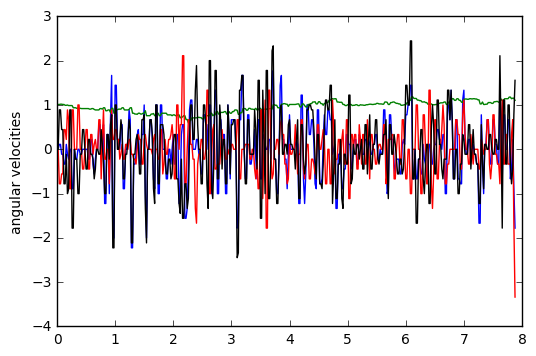

In [42]:
import matplotlib.pyplot as plt
plt.plot(time, l_diff, color = 'b')
plt.plot(time, l, color = 'green')
plt.plot(time, r_diff, color = 'r')
plt.plot(time, lmr_diff, color = 'k')
plt.ylabel('angular velocities')
plt.show()

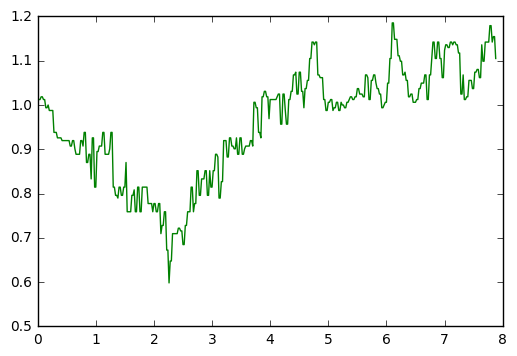

In [43]:
plt.plot(time, l, color = 'green')

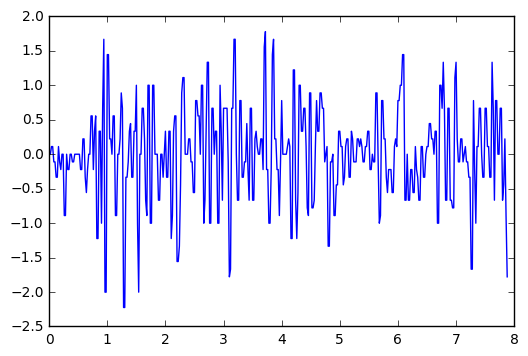

In [44]:
plt.plot(time, l_diff, color = 'b')

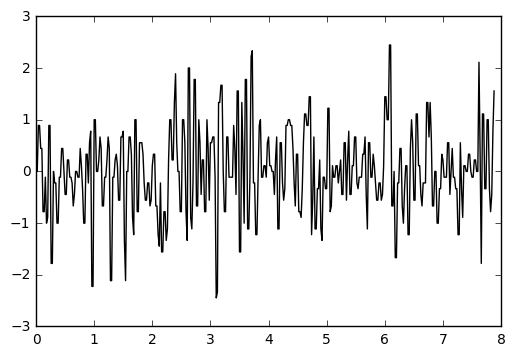

In [45]:
plt.plot(time, lmr_diff, color = 'k')

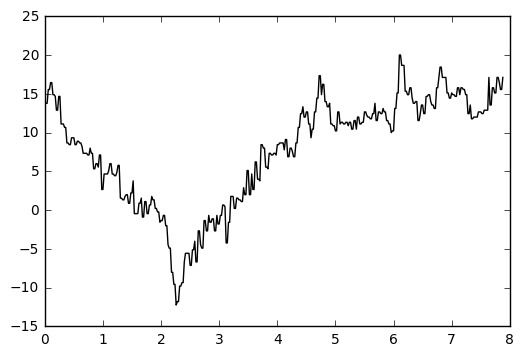

In [46]:
plt.plot(time, lmr, color = 'k')

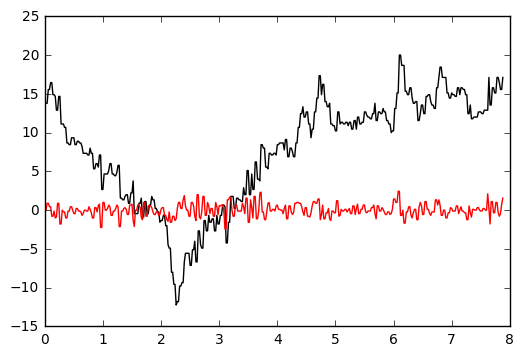

In [47]:
plt.plot(time, lmr, color = 'k')
plt.plot(time, lmr_diff, color = 'r')

In [48]:
def findSacs(WAfilt, wsv,  *args):
    """
    Finds events, or saccades, defined as local min-/maxima of trace velocity (wsv) within threshold/ceiling bounds 
    
    USAGE EXAMPLE:
    $ import numpy as np
    $ import Sac_ID_wsv as sid
    $ WAfilt                 = AF - np.nanmean(AF) # mean deduct the angle trace
    $ SAx, SAn, SVx, SVn  = sid.findSacs(WAfilt, wsv, fVec, fs, 20., 180., 6., 90.)
    # Or, if you want to use default values:
    $ SAx, SAn, SVx, SVn  = sid.findSacs(traceToID, wsv)
    
    IN:
    WAfilt:    The wing angle vector, for instance the LmR wing angle differential, kalman-filtered (filtering method does not matter)
    wsv:    Time-derivative of WAfilt, can be derived manually, or obtained from the kalman filter
    fVec:   A np.zeros vector with NaN entries where the fly was not flying
    fs:     The sampling frequency
    wsvThresh, wsvCeil, magThresh: saccade identifier parameters: velocity threshold, ceiling, and magnitude threshold (latter only used to exclude rebounds)
    
    OUT:
    SAmx, SAmn, SVmx, SVmn: np.nan vectors with Saccade Angles or Saccade Velocities in positive and negative directions, respectively
    
    QUESTIONS?
    ivo.ros@gmail.com

    """
    ## Local functions (inside this function, so they don't need to be separately defined)
    import numpy as np

    def calcMag(idx, wsv, WAfilt): # calculate difference in L-R WSA between nearest local extremes (of opposite sign)
            k=0
            chkMore=True
            refSign=np.sign(wsv[idx])
            while chkMore:
                k += 1
                compSign=np.sign(wsv[idx-k])
                if refSign != compSign: # if not equal
                    onIdx=idx-k+1
                    chkMore=False
            k=0
            chkMore=True
            while chkMore and k < 44:
                k += 1
#                print k
                compSign=np.sign(wsv[idx+k])
                if refSign != compSign:
                    offIdx=idx+k
                    chkMore=False
            if k == 44:  # dirty fail save
                offIdx=idx+k
            return WAfilt[offIdx] - WAfilt[onIdx], onIdx, offIdx # 'integral': BR (behavioral response) = dWSA(offIdx)-dWSA(onIdx)
            
    def sacOnly(inVec, fVec):
        fVecSqz = np.squeeze(fVec)
        outVec = np.array( np.sum([inVec, fVecSqz], axis=0) ).transpose()
        outVec[outVec == 0] = np.nan
        return outVec
            
    ### end of local functions
            
    ## check for arguments
    # Hardcoded default values (used when not included in function call varargs)
                                                            #flight vector,        recFreq wsvThr, Ceil,    magThr
    deffVec, deffs, defwsvThresh, defwsvCeil, defmagThresh = np.zeros_like(WAfilt),   64.,    20,     140.,    6.      # default values
    varargin = args
    nargin = 1 + len(varargin)
    if nargin == 1:
        fVec, fs, wsvThresh, wsvCeil, magThresh = deffVec, deffs, defwsvThresh, defwsvCeil, defmagThresh
    elif nargin == 2:
        fs, wsvThresh, wsvCeil, magThresh = deffs, defwsvThresh, defwsvCeil, defmagThresh
        fVec = varargin[0]
    elif nargin == 3:
        wsvThresh, wsvCeil, magThresh = defwsvThresh, defwsvCeil, defmagThresh
        fVec, fs = varargin[0], varargin[1]
    elif nargin == 4:
        wsvCeil, magThresh = defwsvCeil, defmagThresh
        fVec, fs, wsvThresh = varargin[0], varargin[1], varargin[2]
    elif nargin == 5:
        magThresh = defmagThresh
        fVec, fs, wsvThresh, wsvCeil = varargin[0], varargin[1], varargin[2], varargin[3]
    elif nargin == 6:
        fVec, fs, wsvThresh, wsvCeil, magThresh = varargin[0], varargin[1], varargin[2], varargin[3], varargin[4]
    else:
        print 'could not assign all parameters'

    # In words: find local extremes that exceed wsv threshold during flight
    # subsequently, integrate the unidirectional wsv sections surrounding local extremes, 
    # and retain only those which amplitudes surpasses a threshold amplitude.        
    
    ## Place holders
    wsvMxThr,       wsvMnThr    = np.zeros_like(wsv), np.zeros_like(wsv) 
    SwsvMx,         SwsvMn      = np.zeros_like(wsv), np.zeros_like(wsv)
    lcMxMagTemp,    lcMnMagTemp = np.zeros_like(wsv), np.zeros_like(wsv)
    lcMxMag,        lcMnMag     = np.zeros_like(wsv), np.zeros_like(wsv) 
    sacMx,          sacMn       = np.zeros_like(wsv), np.zeros_like(wsv)
    lcMnonIdx,      lcMnoffIdx  = np.zeros_like(wsv), np.zeros_like(wsv)
    lcMxonIdx,      lcMxoffIdx  = np.zeros_like(wsv), np.zeros_like(wsv)
    lcMxdeltaIdx,   lcMndeltaIdx= np.zeros_like(wsv), np.zeros_like(wsv)
    SacAngMx,       SacAngMn    = np.zeros_like(wsv), np.zeros_like(wsv)
    SacIdxMx,       SacIdxMn    = np.zeros_like(wsv), np.zeros_like(wsv)
        
    ## Find local extremes in the rate, that exceed the saccade velocity threshold
    reboundIds = int(.5*fs)
    for idx in range (reboundIds,len(wsv)-reboundIds):
        if wsv[idx]>=wsv[idx-1] and wsv[idx]>=wsv[idx+1] and wsv[idx]>wsvThresh and wsv[idx]<wsvCeil:
            wsvMxThr[idx] = wsv[idx]
        elif wsv[idx]<=wsv[idx-1] and wsv[idx]<=wsv[idx+1] and wsv[idx]<-wsvThresh and wsv[idx]>-wsvCeil:
            wsvMnThr[idx] = wsv[idx]
    
    ## Calculate a steering magnitude
    # Integrate unidirectional wsv sections surrounding local extremes to obtain saccade magnitude
    for idx in range (int(1.1*reboundIds),len(wsv)-int(1.1*reboundIds)):
        if abs(wsvMxThr[idx])>0: # for every local max
            lcSteerMag, onIdx, offIdx = calcMag(idx, wsv, WAfilt)
            if lcSteerMag > magThresh:
                lcMxMagTemp[idx] = lcSteerMag 
                lcMxonIdx[idx] = onIdx
                lcMxoffIdx[idx] = offIdx
                lcMxdeltaIdx[idx] = offIdx-idx
        if abs(wsvMnThr[idx])>0: # for every local minimum
            lcSteerMag, onIdx, offIdx = calcMag(idx, wsv, WAfilt)
            if lcSteerMag < -magThresh:
                lcMnMagTemp[idx] = lcSteerMag
                lcMnonIdx[idx] = onIdx
                lcMnoffIdx[idx] = offIdx
                lcMndeltaIdx[idx] = offIdx-idx
    
    ## Obtain saccades, retained extremes that are not 'rebounds' (stable pre-onset activity for .5s).
    # Note that steering magnitude is only used to detect rebounds, not to identify saccades
    for idx in range (reboundIds,len(wsv)-reboundIds):
        if lcMxMagTemp[idx]>0: # for every local maximum that exceeds the magnitude threshold
            if abs(np.sum(lcMnMagTemp[idx-reboundIds:idx]))<magThresh and ~np.isnan(fVec[idx-reboundIds:idx+reboundIds]).any(axis=0): 
                SwsvMx[idx] = wsv[idx]
                lcMxMag[idx] = lcMxMagTemp[idx]
                sacMx[int(lcMxonIdx[idx]):int(lcMxoffIdx[idx])] = WAfilt[int(lcMxonIdx[idx]):int(lcMxoffIdx[idx])]
                sacPeakIdx = int(idx+lcMxdeltaIdx[idx])
                SacAngMx[sacPeakIdx] = WAfilt[sacPeakIdx]                       # such that saccades can be indicated at peaks 
                SacIdxMx[idx] = sacPeakIdx                                      # indices of saccades, to allow cropping of saccades
        elif lcMnMagTemp[idx]<0: # for every local minimum that exceeds the magnitude threshold
            if abs(np.sum(lcMxMagTemp[idx-reboundIds:idx]))<magThresh and ~np.isnan(fVec[idx-reboundIds:idx+reboundIds]).any(axis=0): 
                SwsvMn[idx] = wsv[idx]
                lcMnMag[idx] = lcMnMagTemp[idx]
                sacMn[int(lcMnonIdx[idx]):int(lcMnoffIdx[idx])] = WAfilt[int(lcMnonIdx[idx]):int(lcMnoffIdx[idx])]
                sacPeakIdx = int(idx+lcMndeltaIdx[idx])
                SacAngMn[sacPeakIdx] = WAfilt[sacPeakIdx]
                SacIdxMn[idx] = sacPeakIdx                                      # indices of saccades, to allow cropping of saccades
      
    ## only when fly is flying, set all other instances to nan    
    SAmx,    SAmn    = sacOnly(SacAngMx, fVec), sacOnly(SacAngMn, fVec)
    SVmx,    SVmn    = sacOnly(SwsvMx,   fVec), sacOnly(SwsvMn,   fVec)
    #SMagMx,  SMagMn  = sacOnly(lcMxMag,  fVec), sacOnly(lcMnMag,  fVec)
    #SIdxmx,  SIdxmn  = sacOnly(SacIdxMx, fVec), sacOnly(SacIdxMn, fVec)    
    #you can also return the following: SMagMx, SMagMn, SIdxmx,  SIdxmn
    return SAmx,   SAmn,   SVmx, SVmn,  # [traceAngle, at saccade max peak;; peakAngVelo, at its Idx;; saccadePeakAngleIndex at peak angVelo index;  turnAngle]


In [54]:
#from pykalman import KalmanFilter
import numpy as np

from scipy.stats import norm
